# Loading helper libraries 

In [36]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import re
import ast
import patsy
import datetime
import math

from pathlib import Path
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from plotnine import *
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse
from collections import defaultdict
from sklearn.linear_model import Lasso
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from plotnine.data import mpg
from mizani.formatters import percent_format



In [37]:
path = Path(os.getcwd())
tech_prep = os.path.join(str(path), "utils")
sys.path.append(tech_prep)
from py_helper_functions import *

# Loading Dataset 

### 1. main_df is the main dataset for my city, Lisbon.
### 2. amenities_cleaned_df is the dataset used for mapping amenities to my definitons

In [38]:
main_df = pd.read_csv('https://raw.githubusercontent.com/arbash-malik/DA3/main/Assignment%202/lisbon_listings.csv', delimiter=",",encoding="utf-8")
amenities_cleaned_df = pd.read_csv('https://raw.githubusercontent.com/arbash-malik/DA3/main/Assignment%202/unique_amenities_cleaned.csv', delimiter=",",encoding="utf-8")


In [39]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22605 entries, 0 to 22604
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            22605 non-null  int64  
 1   listing_url                                   22605 non-null  object 
 2   scrape_id                                     22605 non-null  int64  
 3   last_scraped                                  22605 non-null  object 
 4   source                                        22605 non-null  object 
 5   name                                          22605 non-null  object 
 6   description                                   22586 non-null  object 
 7   neighborhood_overview                         13429 non-null  object 
 8   picture_url                                   22605 non-null  object 
 9   host_id                                       22605 non-null 

#### Since our client  will be operating small and mid-size apartments hosting 2-6 guests. It makes sense to filter out listings that are a room or a shared unit and only keep the ones that a customer can book entirely

In [40]:
main_df = main_df[main_df["property_type"].str.contains(r'^Entire', regex=True)] # fitlering for entire property types
main_df = main_df.loc[(main_df['accommodates'] >= 2) & (main_df['accommodates'] <= 6)] # fitlering for 2-6 accommodates

In [41]:
main_df.head().T

,0,1,2,3,5
id,6499,25659,119120,29248,29396
listing_url,https://www.airbnb.com/rooms/6499,https://www.airbnb.com/rooms/25659,https://www.airbnb.com/rooms/119120,https://www.airbnb.com/rooms/29248,https://www.airbnb.com/rooms/29396
scrape_id,20230911050651,20230911050651,20230911050651,20230911050651,20230911050651
last_scraped,2023-09-11,2023-09-12,2023-09-12,2023-09-12,2023-09-12
source,city scrape,city scrape,city scrape,city scrape,city scrape
...,...,...,...,...,...
calculated_host_listings_count,1,1,8,5,1
calculated_host_listings_count_entire_homes,1,1,8,5,1
calculated_host_listings_count_private_rooms,0,0,0,0,0
calculated_host_listings_count_shared_rooms,0,0,0,0,0


# Data Cleaning and Data Preparation
1. cleaning `amenities` columns (grouping by category using amenities_cleaned_df) # this was done seperately as code was very long to include
2. getting number of bathrooms from `bathroom_texts` 

In [42]:
main_df['amenities'][0] #exploring our amenities columns

'["Shampoo", "River view", "Dishes and silverware", "Dining table", "Stove", "Coffee maker", "Paid street parking off premises", "Kitchen", "Microwave", "Freezer", "Bed linens", "Paid parking on premises", "Laundromat nearby", "Oven", "Host greets you", "Carbon monoxide alarm", "Mini fridge", "Ethernet connection", "TV with standard cable", "First aid kit", "Hot water", "Extra pillows and blankets", "Cooking basics", "Wifi", "Essentials", "Cleaning products", "Fire extinguisher", "Free street parking", "Room-darkening shades", "Free washer \\u2013 In unit", "Long term stays allowed"]'

In [43]:
# cleaning the amenities column
main_df["amenities"] = main_df["amenities"].astype(str).str.strip("[]").str.replace('"', "").str.split(",")

In [44]:
# cleaning the amenities column
old_value1 = '\\u2019n '
old_value2 = '\\u2013 '
old_value3 = '\\'
new_value = ''


main_df['amenities'] = main_df['amenities'].apply(lambda x: [item.replace(old_value1, new_value) for item in x])
main_df['amenities'] = main_df['amenities'].apply(lambda x: [item.replace(old_value2, new_value) for item in x])
main_df['amenities'] = main_df['amenities'].apply(lambda x: [item.replace(old_value3, new_value) for item in x])



In [45]:
# replacing and mapping values as defined by me in the unique cleaned amenities dataset

replacement_dict = dict(zip(amenities_cleaned_df['original'], amenities_cleaned_df['new']))

main_df['amenities_cleaned'] = main_df['amenities'].apply(lambda x: [replacement_dict[val] if val in replacement_dict else val for val in x])

print(sorted(main_df["amenities_cleaned"].explode().unique()))

['', 'airconditioning', 'backyard', 'bbq', 'beachaccess', 'bodysoap', 'breakfast', 'cabletv', 'closet', 'coffeemaker', 'conditioner', 'dishwasher', 'dryer', 'elevator', 'essentials', 'fireextinguisher', 'firstaidkit', 'freeparking', 'gameconsole', 'gym', 'hairdryer', 'hangers', 'hottub', 'indoorfireplace', 'keypad', 'kidfriendly', 'kitchen', 'lockbox', 'luxuryamenities', 'others', 'outdooramenities', 'paidparking', 'petfriendly', 'pool', 'privateentrance', 'privatelivingroom', 'refrigerator', 'securitycameras', 'selfcheckin', 'shampoo', 'smokedetector', 'smokingallowed', 'soundsystem', 'tv', 'washer', 'wifi', 'windowview', 'workspace']


In [46]:
# extracting bathrooms from bathroom text

def extract_bathrooms(text):
    match = re.match(r'^([\d.]+)\s*baths?', str(text))
    if match:
        return float(match.group(1))
    else:
        return 0

main_df['n_bathrooms'] = main_df['bathrooms_text'].apply(extract_bathrooms)

#### Filtering out irrelevant columns and renaming the relevant ones for better information representing

In [47]:
columns_to_keep = ['property_type','room_type','price','accommodates', 'beds','bedrooms','n_bathrooms',
                   'review_scores_rating', 'host_is_superhost','number_of_reviews', 'minimum_nights', 'maximum_nights', 
                   'reviews_per_month','neighbourhood_cleansed','neighbourhood_group_cleansed','instant_bookable','amenities_cleaned']

filtered_df= main_df[columns_to_keep]

column_renaming = {
    'property_type':'f_property_type',
    'room_type':'f_room_type',
    'accommodates': 'n_accommodates',
    'beds': 'n_beds',
    'bedrooms':'n_bedrooms',
    'minimum_nights': 'n_minimum_nights',
    'maximum_nights': 'n_maximum_nights',
    'instant_bookable': 'd_instant_bookable',
    'host_is_superhost':'d_host_is_superhost',
    'number_of_reviews': 'n_number_of_reviews',
    'reviews_per_month': 'n_reviews_per_month',
    'review_scores_rating': 'n_review_scores_rating',
    'neighbourhood_cleansed': 'f_neighbourhood_cleansed',
    'neighbourhood_group_cleansed': 'f_neighbourhood_group_cleansed',    
}

filtered_df.rename(columns=column_renaming, inplace=True)

#### Transforming variables and cleaning our dependant variable
1. `property type` to category
2. `room type` to category
3. `neighbourhood cleansed` to category
4. `instant bookable` to 1 0
5. `host is super` host to 1 0
6. `price` cleaning

In [48]:

filtered_df["f_property_type"] = filtered_df["f_property_type"].astype("category") # category column for modelling
filtered_df["f_room_type"] = filtered_df["f_room_type"].astype("category") # category column for modelling
filtered_df["f_neighbourhood_cleansed"] = filtered_df["f_neighbourhood_cleansed"].astype("category") # category column for modelling
filtered_df["f_neighbourhood_group_cleansed"] = filtered_df["f_neighbourhood_group_cleansed"].astype("category") # category column for modelling


filtered_df['d_instant_bookable'] = np.where(filtered_df['d_instant_bookable'] == 't', '1', '0') .astype(int) # changing to 1 and 0
filtered_df['d_host_is_superhost'] = np.where(filtered_df['d_host_is_superhost'] == 't', '1', '0') .astype(int) # changing to 1 and 0


# cleaning price variable
filtered_df['price'] = filtered_df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
filtered_df = filtered_df.dropna(subset=['price'])
filtered_df = filtered_df[filtered_df['price'] > 0]
filtered_df['price'] = filtered_df['price'].astype(int) 

In [49]:
# checking for missing values in columns
for col in filtered_df.columns:
    missing_values_col = filtered_df[col].isnull().sum()
    print(f"Missing values for {col}: {missing_values_col}")

Missing values for f_property_type: 0
Missing values for f_room_type: 0
Missing values for price: 0
Missing values for n_accommodates: 0
Missing values for n_beds: 54
Missing values for n_bedrooms: 746
Missing values for n_bathrooms: 0
Missing values for n_review_scores_rating: 1251
Missing values for d_host_is_superhost: 0
Missing values for n_number_of_reviews: 0
Missing values for n_minimum_nights: 0
Missing values for n_maximum_nights: 0
Missing values for n_reviews_per_month: 1251
Missing values for f_neighbourhood_cleansed: 0
Missing values for f_neighbourhood_group_cleansed: 0
Missing values for d_instant_bookable: 0
Missing values for amenities_cleaned: 0


In [50]:
# since missing values are low in number, I am dropping them instead of making flag columns or imputing them

filtered_df.dropna(subset=['n_review_scores_rating','n_bedrooms','n_beds'], inplace=True)

for col in filtered_df.columns:
    missing_values_col = filtered_df[col].isnull().sum()
    print(f"Missing values for {col}: {missing_values_col}")

Missing values for f_property_type: 0
Missing values for f_room_type: 0
Missing values for price: 0
Missing values for n_accommodates: 0
Missing values for n_beds: 0
Missing values for n_bedrooms: 0
Missing values for n_bathrooms: 0
Missing values for n_review_scores_rating: 0
Missing values for d_host_is_superhost: 0
Missing values for n_number_of_reviews: 0
Missing values for n_minimum_nights: 0
Missing values for n_maximum_nights: 0
Missing values for n_reviews_per_month: 0
Missing values for f_neighbourhood_cleansed: 0
Missing values for f_neighbourhood_group_cleansed: 0
Missing values for d_instant_bookable: 0
Missing values for amenities_cleaned: 0


In [51]:
# Creating amenities columns from each amenity for each listing
unique_amenities = set()
for amenities_list in filtered_df['amenities_cleaned']:
    unique_amenities.update(amenities_list)

for amenity in unique_amenities:
    filtered_df['d_' + amenity] = filtered_df['amenities_cleaned'].apply(lambda x: 1 if amenity in x else 0)


In [52]:
# Extra check to ensure our dummy columns are integer columns

dummy_cols = filtered_df.filter(regex='^d_').columns
filtered_df[dummy_cols] = filtered_df[dummy_cols].fillna(0).astype(int)

In [53]:
# Dropping irrelevant columns for a cleaner dataframe

columns_to_drop = ['d_','amenities_cleaned']
clean_df = filtered_df.drop(columns_to_drop, axis=1)

In [54]:
# Final dataframe for use
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12356 entries, 0 to 22535
Data columns (total 63 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   f_property_type                 12356 non-null  category
 1   f_room_type                     12356 non-null  category
 2   price                           12356 non-null  int32   
 3   n_accommodates                  12356 non-null  int64   
 4   n_beds                          12356 non-null  float64 
 5   n_bedrooms                      12356 non-null  float64 
 6   n_bathrooms                     12356 non-null  float64 
 7   n_review_scores_rating          12356 non-null  float64 
 8   d_host_is_superhost             12356 non-null  int32   
 9   n_number_of_reviews             12356 non-null  int64   
 10  n_minimum_nights                12356 non-null  int64   
 11  n_maximum_nights                12356 non-null  int64   
 12  n_reviews_per_month    

#### Combining property types on my definition for better information

In [55]:
clean_df['f_property_type'] = clean_df['f_property_type'].replace({'Entire rental unit': 'Apartment',
'Entire home': 'Home',
'Entire condo': 'Condo',
'Entire serviced apartment': 'Apartment',
'Entire loft': 'Loft',
'Entire villa': 'Loft',
'Entire townhouse': 'Home',
'Entire cottage': 'Home',
'Entire vacation home': 'Home',
'Entire guesthouse': 'Home',
'Entire guest suite': 'Apartment',
'Entire cabin': 'Condo',
'Entire place': 'Apartment',
'Entire chalet': 'Home',
'Entire bungalow':'Home',
'Entire bed and breakfast': 'Home',
'Entire hostel': 'Condo',
'Entire home/apt': 'Home'})

# Exploratory Data Analysis (EDA)

#### Exploring our dependant variable and removing extreme values so my models are better

In [56]:
clean_df.shape

(12356, 63)

In [57]:
clean_df['price'].describe(percentiles = [0.85,0.9,0.95,0.96,0.97,0.98,0.99])

count    12356.000000
mean       148.132001
std        683.564224
min         10.000000
50%        120.000000
85%        195.000000
90%        222.000000
95%        276.000000
96%        295.000000
97%        316.350000
98%        357.000000
99%        446.000000
max      74110.000000
Name: price, dtype: float64

In [58]:
# dropping values over 276 (95% percentile) ~ 700 values
clean_df = clean_df.loc[clean_df['price'] <= 276]

In [59]:
clean_df.shape

(11743, 63)

In [60]:
clean_df['price'].describe(percentiles = [0.85,0.9,0.95,0.96,0.97,0.98,0.99])

count    11743.000000
mean       125.865792
std         48.962625
min         10.000000
50%        118.000000
85%        179.000000
90%        198.000000
95%        225.000000
96%        233.000000
97%        241.000000
98%        250.000000
99%        260.000000
max        276.000000
Name: price, dtype: float64

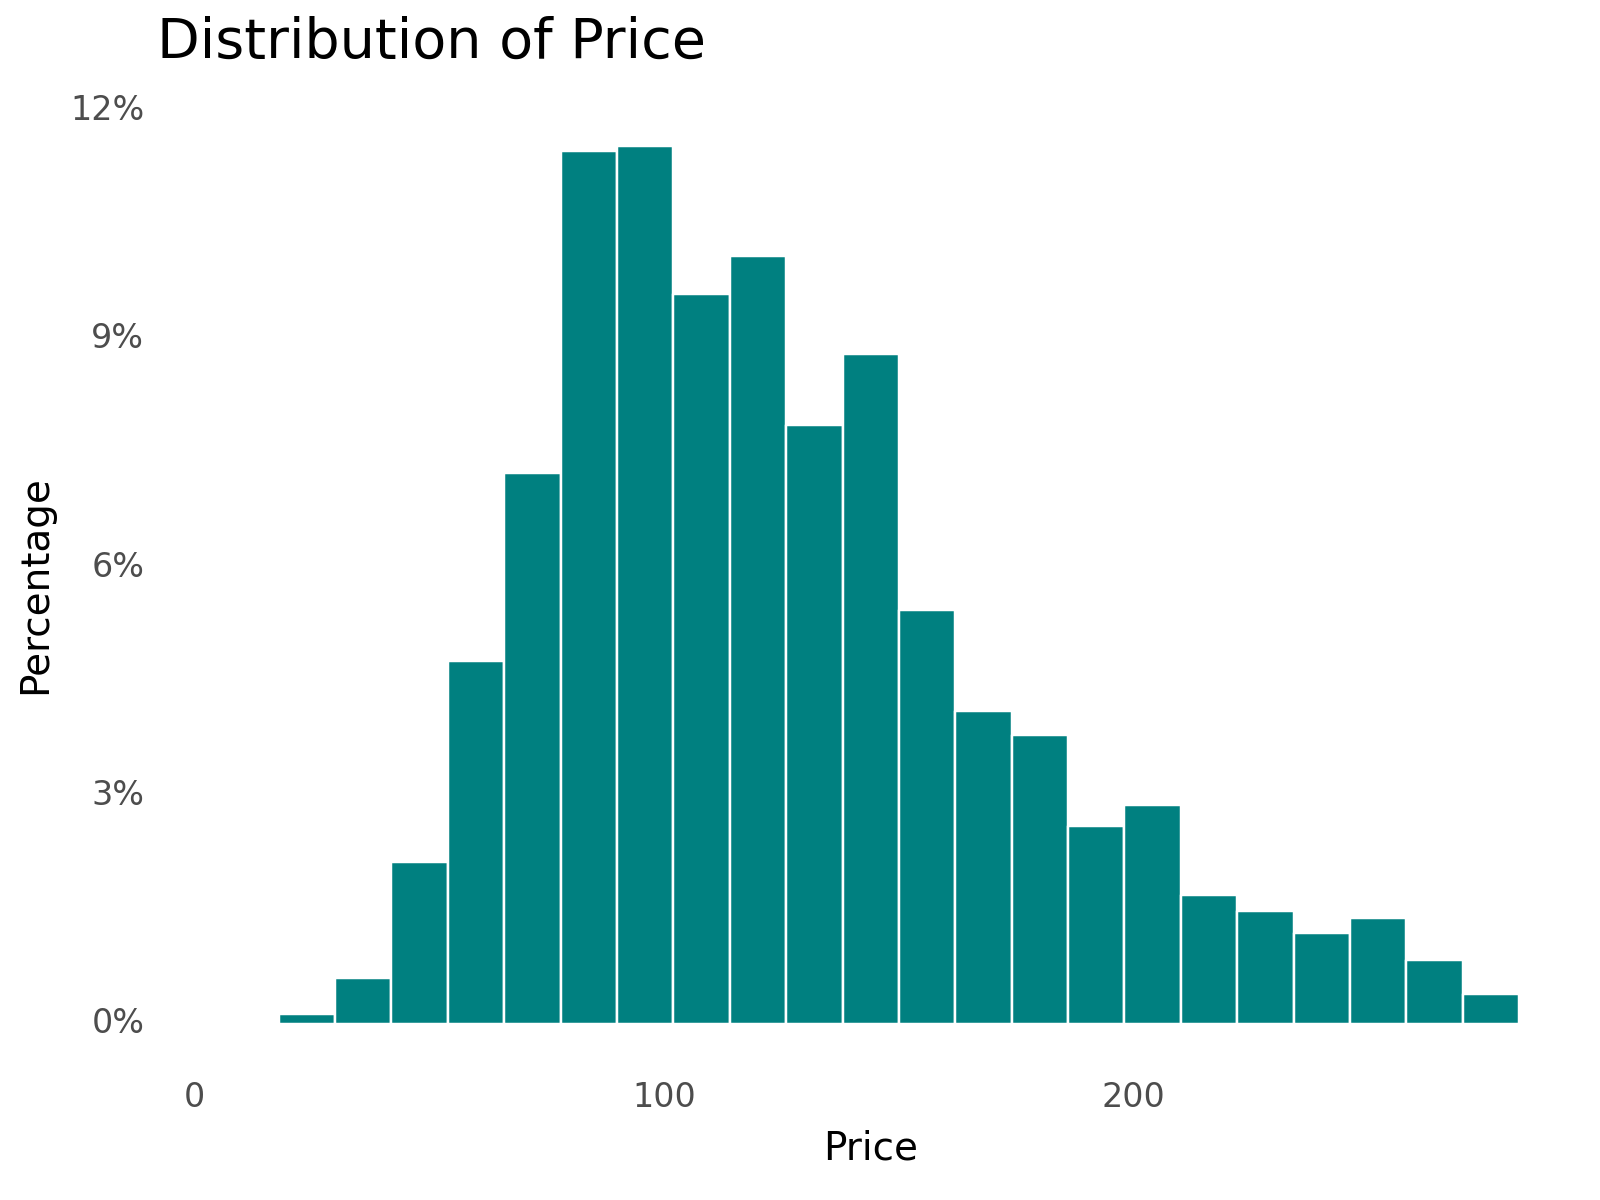

In [61]:
plot = ggplot(clean_df, aes(x='price', y="stat(count)/sum(stat(count))")) + \
       geom_histogram(binwidth=12, fill='#008080', color='white') + \
       labs(title="Distribution of Price", x="Price", y="Percentage") + \
       theme_minimal() + \
       theme(panel_grid_major=element_blank(), panel_grid_minor=element_blank(), 
             plot_title=element_text(size=20), axis_text=element_text(size=12), axis_title=element_text(size=14), 
             figure_size=(8, 6)) + \
       scale_y_continuous(labels=percent_format())

print(plot)

In [62]:
clean_df['f_property_type'].value_counts()

f_property_type
Apartment    9751
Home         1095
Condo         608
Loft          289
Name: count, dtype: int64

In [63]:
clean_df['n_accommodates'].value_counts()

n_accommodates
4    4966
2    2615
6    1929
3    1222
5    1011
Name: count, dtype: int64

In [64]:
clean_df['f_neighbourhood_group_cleansed'].value_counts()

f_neighbourhood_group_cleansed
Lisboa                   8537
Cascais                  1058
Mafra                     683
Sintra                    627
Oeiras                    227
Lourinh                   189
Torres Vedras             145
Amadora                    87
Loures                     85
Odivelas                   39
Alenquer                   21
Vila Franca De Xira        15
Cadaval                    14
Sobral De Monte Agrao       9
Arruda Dos Vinhos           4
Azambuja                    3
Name: count, dtype: int64

In [65]:
clean_df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
price,11743.0,125.87,48.96,10.00,90.00,118.00,153.00,276.00
n_accommodates,11743.0,3.87,1.31,2.00,3.00,4.00,5.00,6.00
n_beds,11743.0,2.31,1.12,1.00,1.00,2.00,3.00,11.00
n_bedrooms,11743.0,1.61,0.69,1.00,1.00,2.00,2.00,6.00
n_bathrooms,11743.0,1.24,0.47,0.00,1.00,1.00,1.00,4.50
n_review_scores_rating,11743.0,4.65,0.41,0.00,4.55,4.75,4.89,5.00
d_host_is_superhost,11743.0,0.32,0.46,0.00,0.00,0.00,1.00,1.00
n_number_of_reviews,11743.0,78.18,98.05,1.00,12.00,39.00,107.00,1002.00
n_minimum_nights,11743.0,3.88,16.13,1.00,2.00,2.00,3.00,1000.00
n_maximum_nights,11743.0,590.12,586.57,2.00,62.00,365.00,1125.00,36180.00


# Modelling

### Shortlisting variables using LASSO
    1. Grouping Variables by topic for easy coding

In [66]:
# Seperating my variables by topic

## basic variables
basic_vars = ["f_property_type","n_accommodates","n_bedrooms","n_bathrooms","n_beds","f_neighbourhood_cleansed"]

## reviews
reviews = ["n_number_of_reviews","n_review_scores_rating",]

## dummies
dummies = list(clean_df.filter(regex="^d_.*"))


## interactions

# for interactions I interacted property types and accommodates with all the dummies
interactions = []

for dummy_col in clean_df.filter(regex="^d_.*"):
    
    interaction_f = 'f_property_type' + '*' + dummy_col + ' + '
    interactions.append(interaction_f)
    
    interaction_n = 'n_accommodates' + '*' + dummy_col + ' + '
    interactions.append(interaction_n)

all_interactions = ''.join(interactions)
all_interactions = all_interactions[:-3]




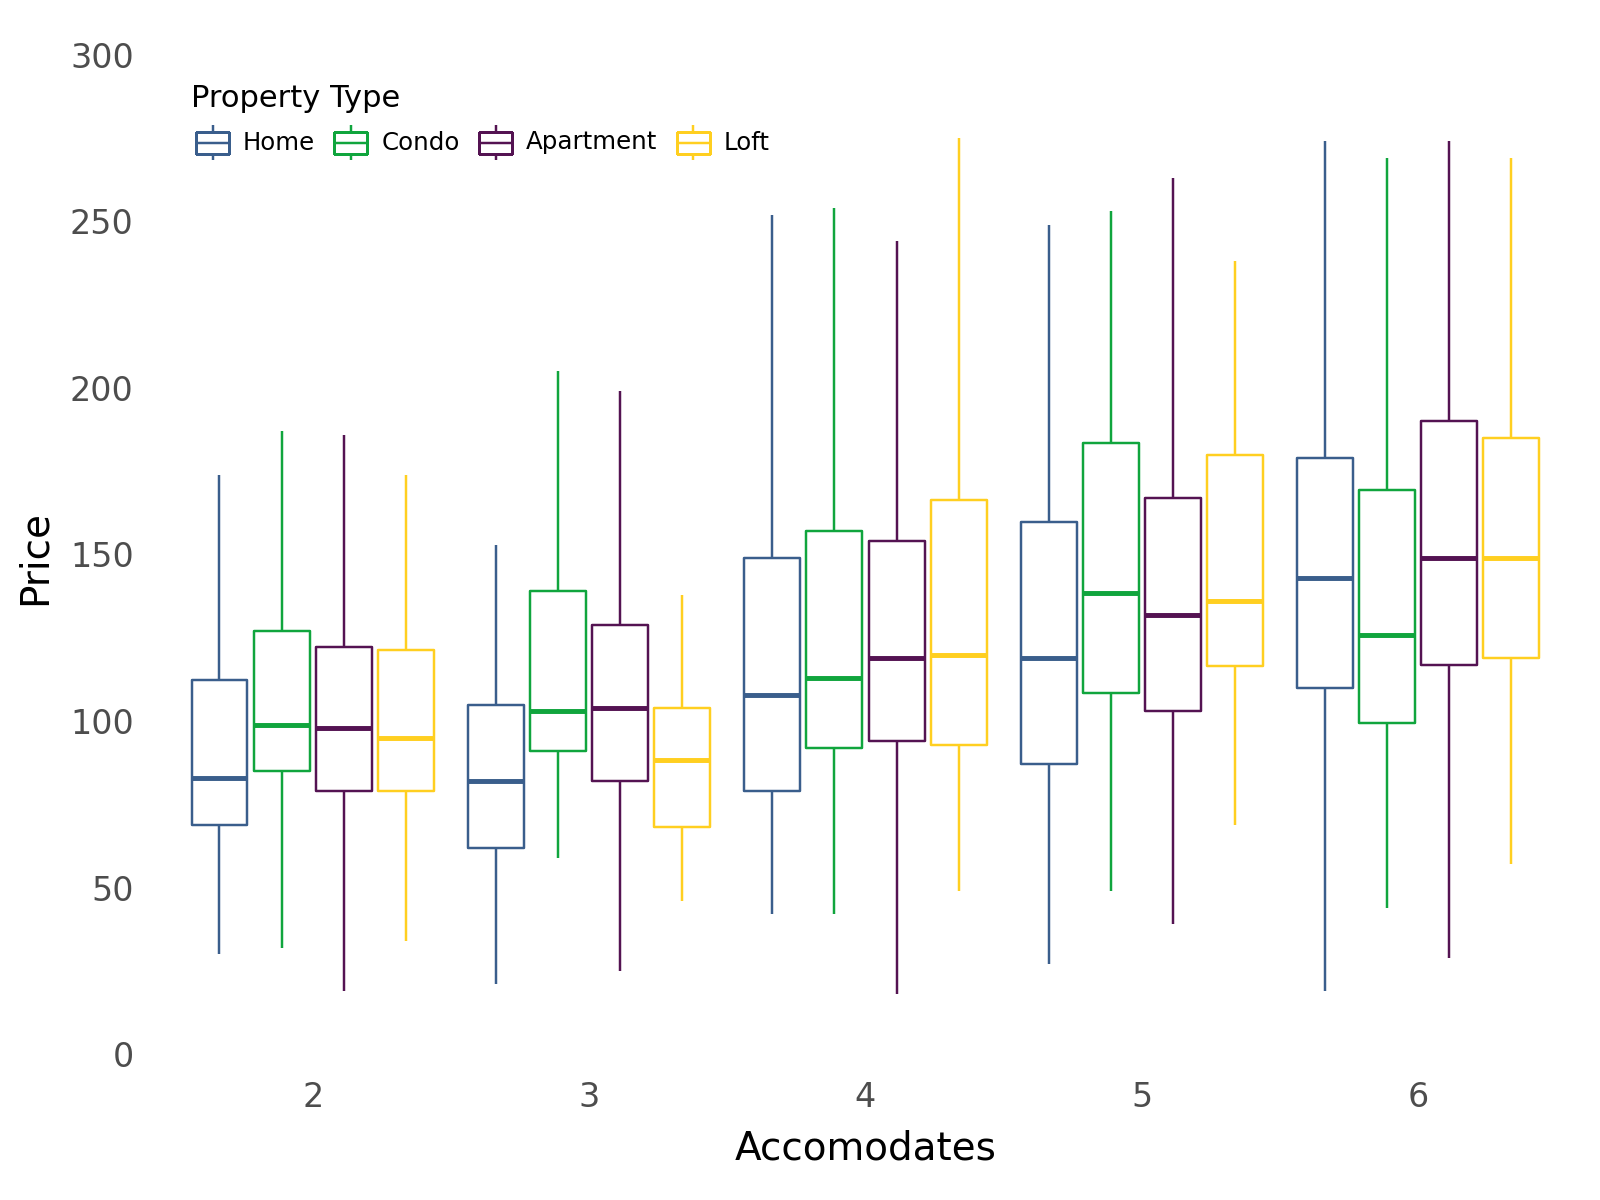

<Figure Size: (800 x 600)>

In [67]:
# Checking if theres need of adding a property and accommodates interactions
(
    ggplot(
        clean_df,
        aes(
            x="factor(n_accommodates)",
            y="price",
            # fill="factor(f_property_type)",
            color="factor(f_property_type)",
        ),
    )
    + geom_boxplot(alpha=0.8, na_rm=True, outlier_shape="", width=0.9, stat="boxplot")
    + scale_color_manual(name="Property Type", values=(color[0], color[1],color[2], color[3]))
    + scale_fill_manual(name="", values=(color[0], color[1], color[2], color[3]))
    + labs(x="Accomodates", y="Price", color="Property Type")
    + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 300), breaks=seq(0, 401, 50))
    + theme_minimal() + 
       theme(legend_position=(0.3, 0.9),panel_grid_major=element_blank(), panel_grid_minor=element_blank(), 
             plot_title=element_text(size=20), axis_text=element_text(size=12), axis_title=element_text(size=14), 
             figure_size=(8, 6))
)


#### As per my decision, I chose not add interactions between property type and accommodates


In [68]:
model1="~"+"+".join(basic_vars)
model2="~"+"+".join(basic_vars)+"+"+"+".join(reviews)+"+"+"+".join(dummies)
model3="~"+"+".join(basic_vars)+"+"+"+".join(reviews)+"+"+"+".join(dummies)+"+"+all_interactions


predictors = basic_vars + reviews + dummies

In [69]:
total_variables = model3.split("+")

num_words = len(total_variables)

print("Number of variables before LASSO: ", num_words)

Number of variables before LASSO:  155


#### Note that model 3 is the most complex with all the interactions, and will be used in LASSO to shortlist our variables for usage

*Using Naive Grid Search method*

In [70]:
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
y, X = patsy.dmatrices("price" + model3, clean_df)

In [71]:
smp_size = round(0.2 * clean_df.shape[0])-1
smp_size

2348

In [72]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=smp_size, random_state=10
)

lambdas = [i/100 for i in range(5, 100,5)]

train_r_squared = np.zeros(len(lambdas))
test_r_squared = np.zeros(len(lambdas))

pred_num = X.shape[1]
coeff_a = np.zeros((len(lambdas), pred_num))

In [73]:
for ind, i in enumerate(lambdas):
    print(f"Run: {str(ind).rjust(2)}, lambda: {i:.2f}, start: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    reg = Lasso(alpha = i, random_state= 20240115)
    reg.fit(X_train, y_train)
    results = cross_val_score(reg, X, y, cv=cv, scoring="r2")

    train_r_squared[ind] = reg.score(X_train, y_train)    
    test_r_squared[ind] = reg.score(X_test, y_test)

Run:  0, lambda: 0.05, start: 2024-02-11 16:10:35
Run:  1, lambda: 0.10, start: 2024-02-11 16:10:46
Run:  2, lambda: 0.15, start: 2024-02-11 16:10:52
Run:  3, lambda: 0.20, start: 2024-02-11 16:10:56
Run:  4, lambda: 0.25, start: 2024-02-11 16:11:00
Run:  5, lambda: 0.30, start: 2024-02-11 16:11:03
Run:  6, lambda: 0.35, start: 2024-02-11 16:11:05
Run:  7, lambda: 0.40, start: 2024-02-11 16:11:08
Run:  8, lambda: 0.45, start: 2024-02-11 16:11:10
Run:  9, lambda: 0.50, start: 2024-02-11 16:11:12
Run: 10, lambda: 0.55, start: 2024-02-11 16:11:14
Run: 11, lambda: 0.60, start: 2024-02-11 16:11:16
Run: 12, lambda: 0.65, start: 2024-02-11 16:11:18
Run: 13, lambda: 0.70, start: 2024-02-11 16:11:20
Run: 14, lambda: 0.75, start: 2024-02-11 16:11:22
Run: 15, lambda: 0.80, start: 2024-02-11 16:11:24
Run: 16, lambda: 0.85, start: 2024-02-11 16:11:26
Run: 17, lambda: 0.90, start: 2024-02-11 16:11:27
Run: 18, lambda: 0.95, start: 2024-02-11 16:11:29


In [74]:
r_squared_data = (
    pd.DataFrame(
        {
            "$R^2$ Test set": test_r_squared,
            "$R^2$ Training set": train_r_squared,
            "lambda": lambdas,
        }
    )
    .melt(id_vars=["lambda"])
)

r_squared_data["variable"] = r_squared_data["variable"].astype("category").cat.reorder_categories(
    ["$R^2$ Training set", "$R^2$ Test set"]
)


#### Comparing our training and tests sets, $R^{2}$ with our Lambdas

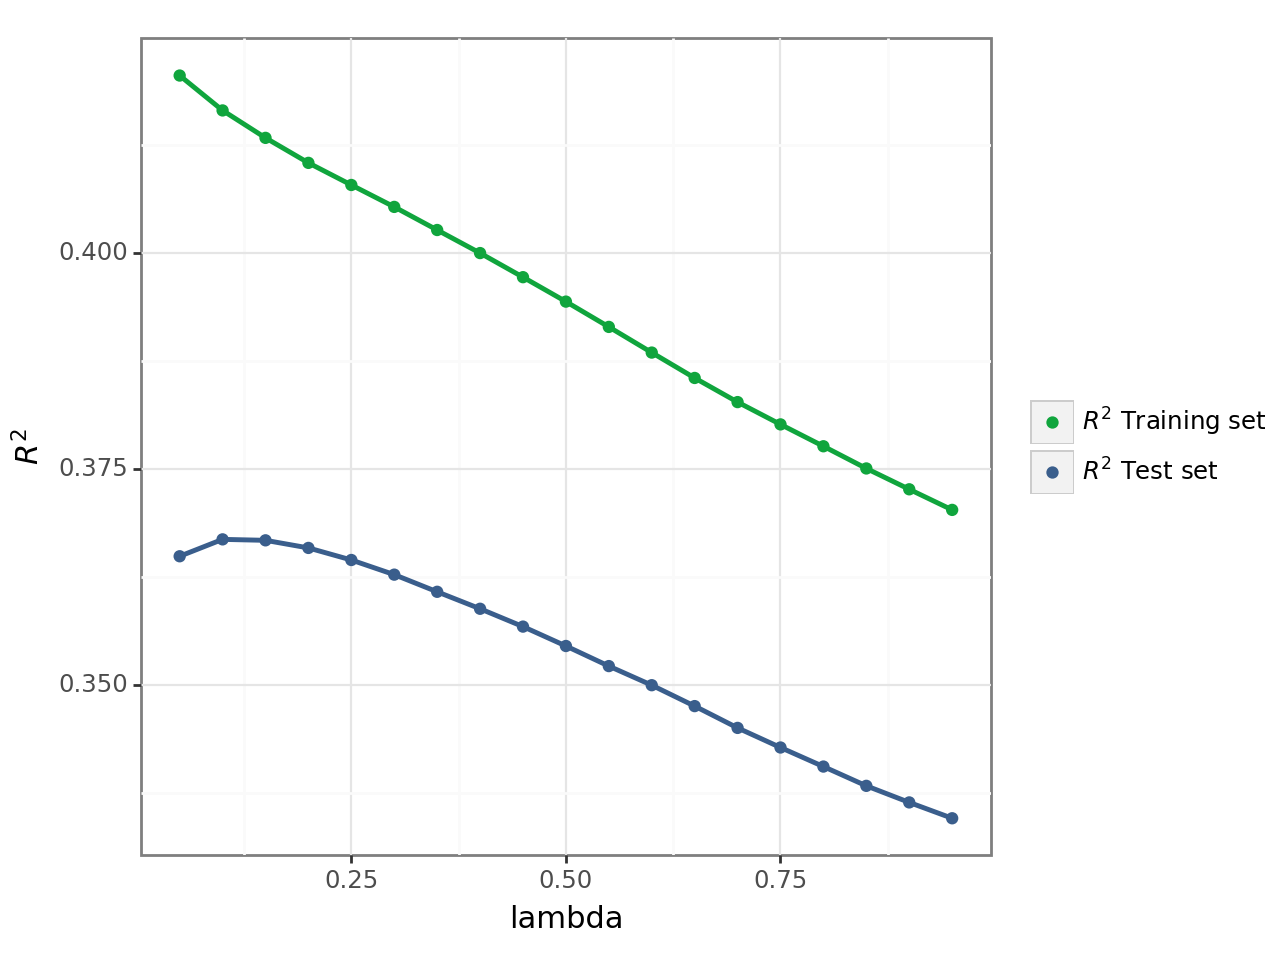

<Figure Size: (640 x 480)>

In [75]:
(
    ggplot(r_squared_data, aes(x="lambda", y="value", color="variable"))
    + geom_point()
    + geom_line(size=1, show_legend=False, na_rm=True)
    + scale_color_manual(name="", values=(color[1], color[0]))
    + scale_y_continuous(name="$R^2$")
    + theme_bw()
    + theme(subplots_adjust={"wspace": 0.25},legend_title=element_blank())
)

In [76]:
df_lam = pd.DataFrame(test_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
# returns the index of the row where column has maximum value.
df_lam.loc[df_lam['R_squared'].idxmax()]

R_squared    36.688222
lambda        0.100000
Name: 1, dtype: float64

In [77]:
reg_best = Lasso(alpha = df_lam.loc[df_lam['R_squared'].idxmax()]['lambda'])
reg_best.fit(X_train, y_train)

Lasso(alpha=0.1)

In [78]:
coefficients = reg_best.coef_[reg_best.coef_>0]

# Print the coefficients along with their corresponding feature names
for feature, coefficient in zip(model3.split('+'), coefficients):
    print(f"{feature.strip()}: {coefficient}")

~f_property_type: 0.5453955747979116
n_accommodates: 0.5885871847354722
n_bedrooms: 0.441638555409902
n_bathrooms: 0.20120084806143654
n_beds: 2.7102208332222775
f_neighbourhood_cleansed: 1.0662143453360082
n_number_of_reviews: 0.4963459764746817
n_review_scores_rating: 1.531987477824882
d_host_is_superhost: 0.21520826727098782
d_instant_bookable: 4.674388911474586
d_workspace: 0.8697014623519185
d_airconditioning: 0.3202540698180346
d_selfcheckin: 3.7143911454311493
d_smokingallowed: 0.014860089145839016
d_firstaidkit: 0.1660670966354052
d_luxuryamenities: 10.088942012089127
d_bbq: 0.00686637473134893
d_windowview: 2.352349363779346
d_essentials: 0.24154148705291303
d_hangers: 11.950886439224135
d_securitycameras: 5.336049583593
d_privateentrance: 0.5260888266055657
d_washer: 4.043489642165443
d_fireextinguisher: 0.056611759506841615
d_hottub: 1.1421396513985536
d_dishwasher: 7.854216722963027
d_wifi: 8.676359415110115
d_keypad: 1.5109469958698627
d_kidfriendly: 2.095508974849328
d_sh

In [79]:
coefficients_data = [
    (feature.strip(), coefficient) 
    for feature, coefficient in zip(model3.split('+'), coefficients)
]

coefficients_df = pd.DataFrame(coefficients_data, columns=['Feature', 'Coefficient'])



<b>*According to LASSO, 113 variables should be used (based on my given strictness value of 0)*

In [80]:
coefficients_df['Feature'] = coefficients_df['Feature'].str.replace('~','')
coefficients_df['Feature'] = coefficients_df['Feature'].str.replace(')','')
coefficients_df['Feature'] = coefficients_df['Feature'].str.replace('(','')
coefficients_df.shape

(112, 2)

In [81]:
coefficients_df

,Feature,Coefficient
0,f_property_type,0.545396
1,n_accommodates,0.588587
2,n_bedrooms,0.441639
3,n_bathrooms,0.201201
4,n_beds,2.710221
...,...,...
107,f_property_type*d_tv,1.776521
108,n_accommodates*d_tv,2.763664
109,f_property_type*d_privatelivingroom,1.721750
110,n_accommodates*d_privatelivingroom,0.264573


In [82]:
num_words = coefficients_df.shape[0]

print("Number of variables after LASSO: ", num_words)

Number of variables after LASSO:  112


In [83]:
def interactions(df, factor_var, dummy_var, factor_lab, dummy_lab):
    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=("price", np.mean), sd=("price", np.std), size=("price", "size")
    )
    stats["se"] = stats["sd"] / stats["size"] ** (1 / 2)
    stats["Mean_l"] = stats["Mean"] - (1.96 * stats["se"])
    stats["Mean_u"] = stats["Mean"] + (1.96 * stats["se"])
    stats = stats.drop(["sd", "size"], axis=1).reset_index()
    plot = (
        ggplot(
            stats,
            aes(
                stats.columns[0],
                stats.columns[2],
                fill="factor(" + stats.columns[1] + ")",
            ),
        )
        + geom_bar(stat="identity", position=position_dodge(width=0.9))
        + geom_errorbar(
            aes(ymin="Mean_l", ymax="Mean_u"),
            position=position_dodge(width=0.9),
            width=0.25,
        )
        + scale_color_manual(name=dummy_lab, values=("#A2A4A2", "#008080"))
        + scale_fill_manual(name=dummy_lab, values=("#A2A4A2", "#008080"))
        + ylab("Mean Price")
        + xlab(factor_lab)
        + theme_bw()
        + theme(
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),
            axis_line=element_line(),
            legend_position="top",
            legend_box="vertical",
            legend_text=element_text(size=8),
            legend_title=element_text(size=8, face="bold"),
            figure_size=(8, 6)
        )
    )

    return plot

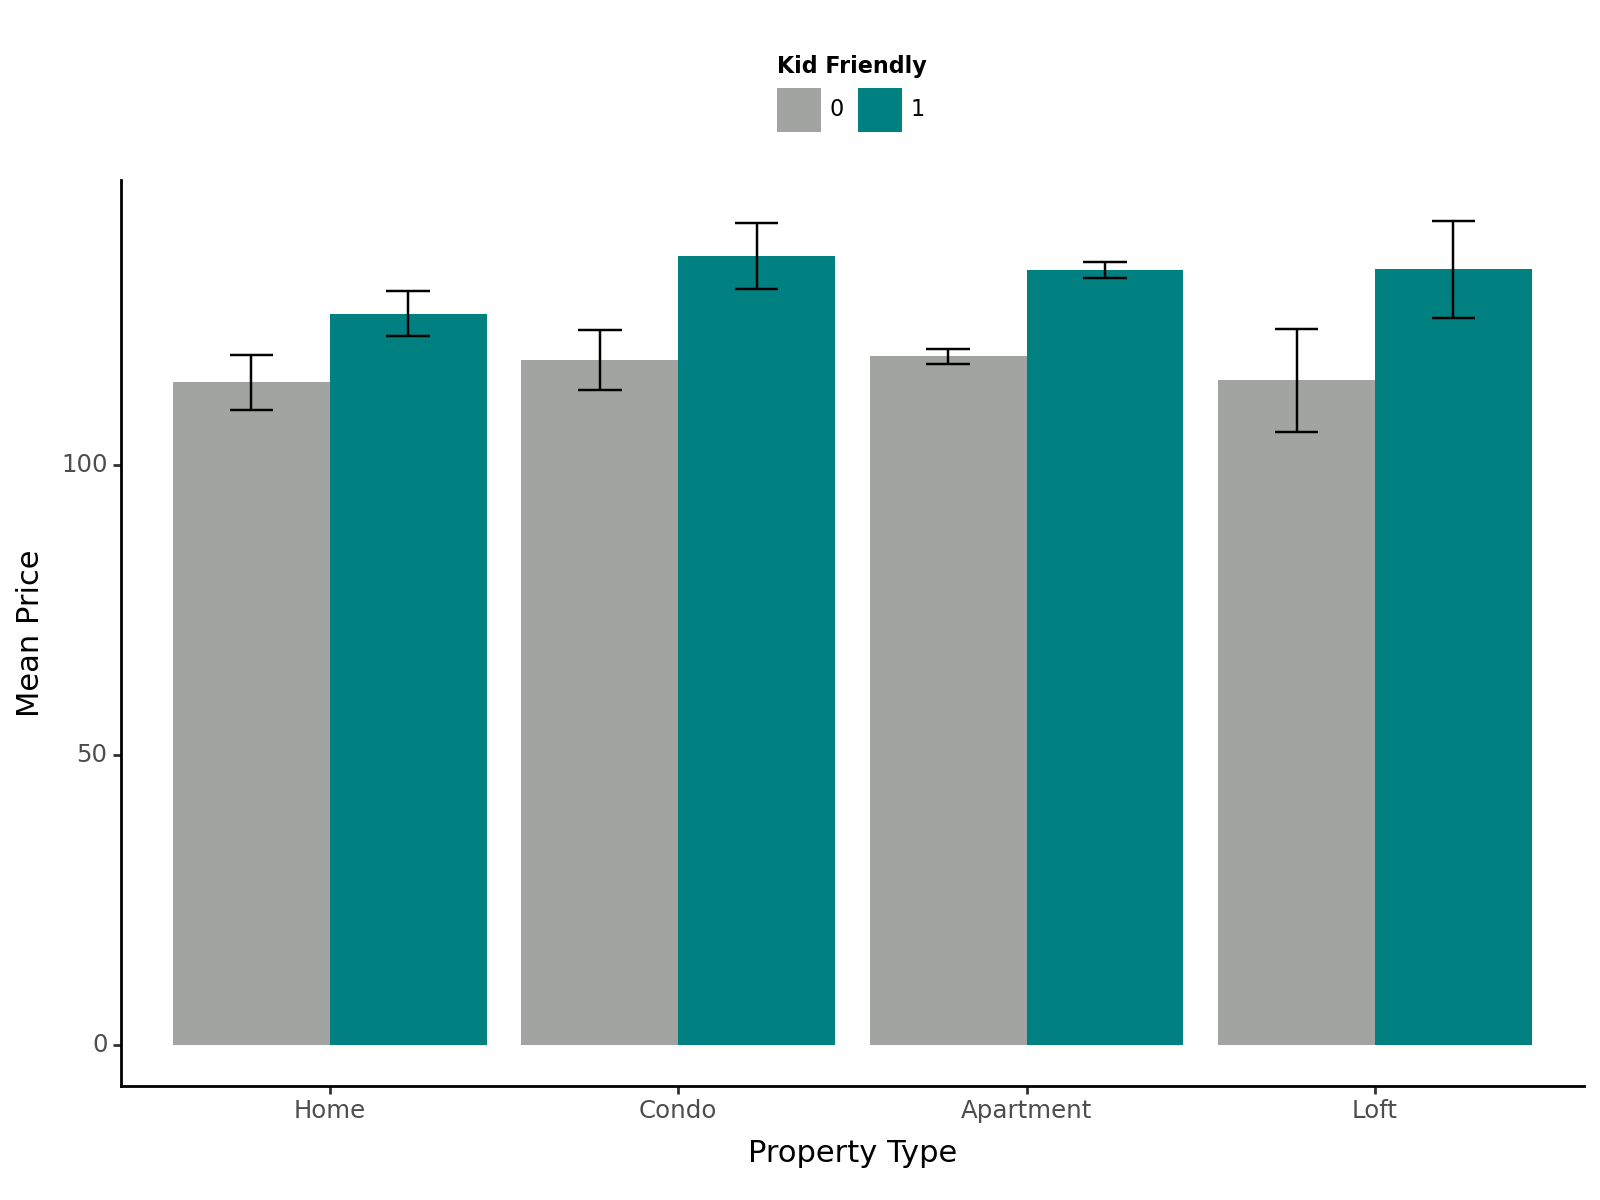

<Figure Size: (800 x 600)>

In [84]:
interactions(clean_df,"f_property_type","d_kidfriendly","Property Type","Kid Friendly")

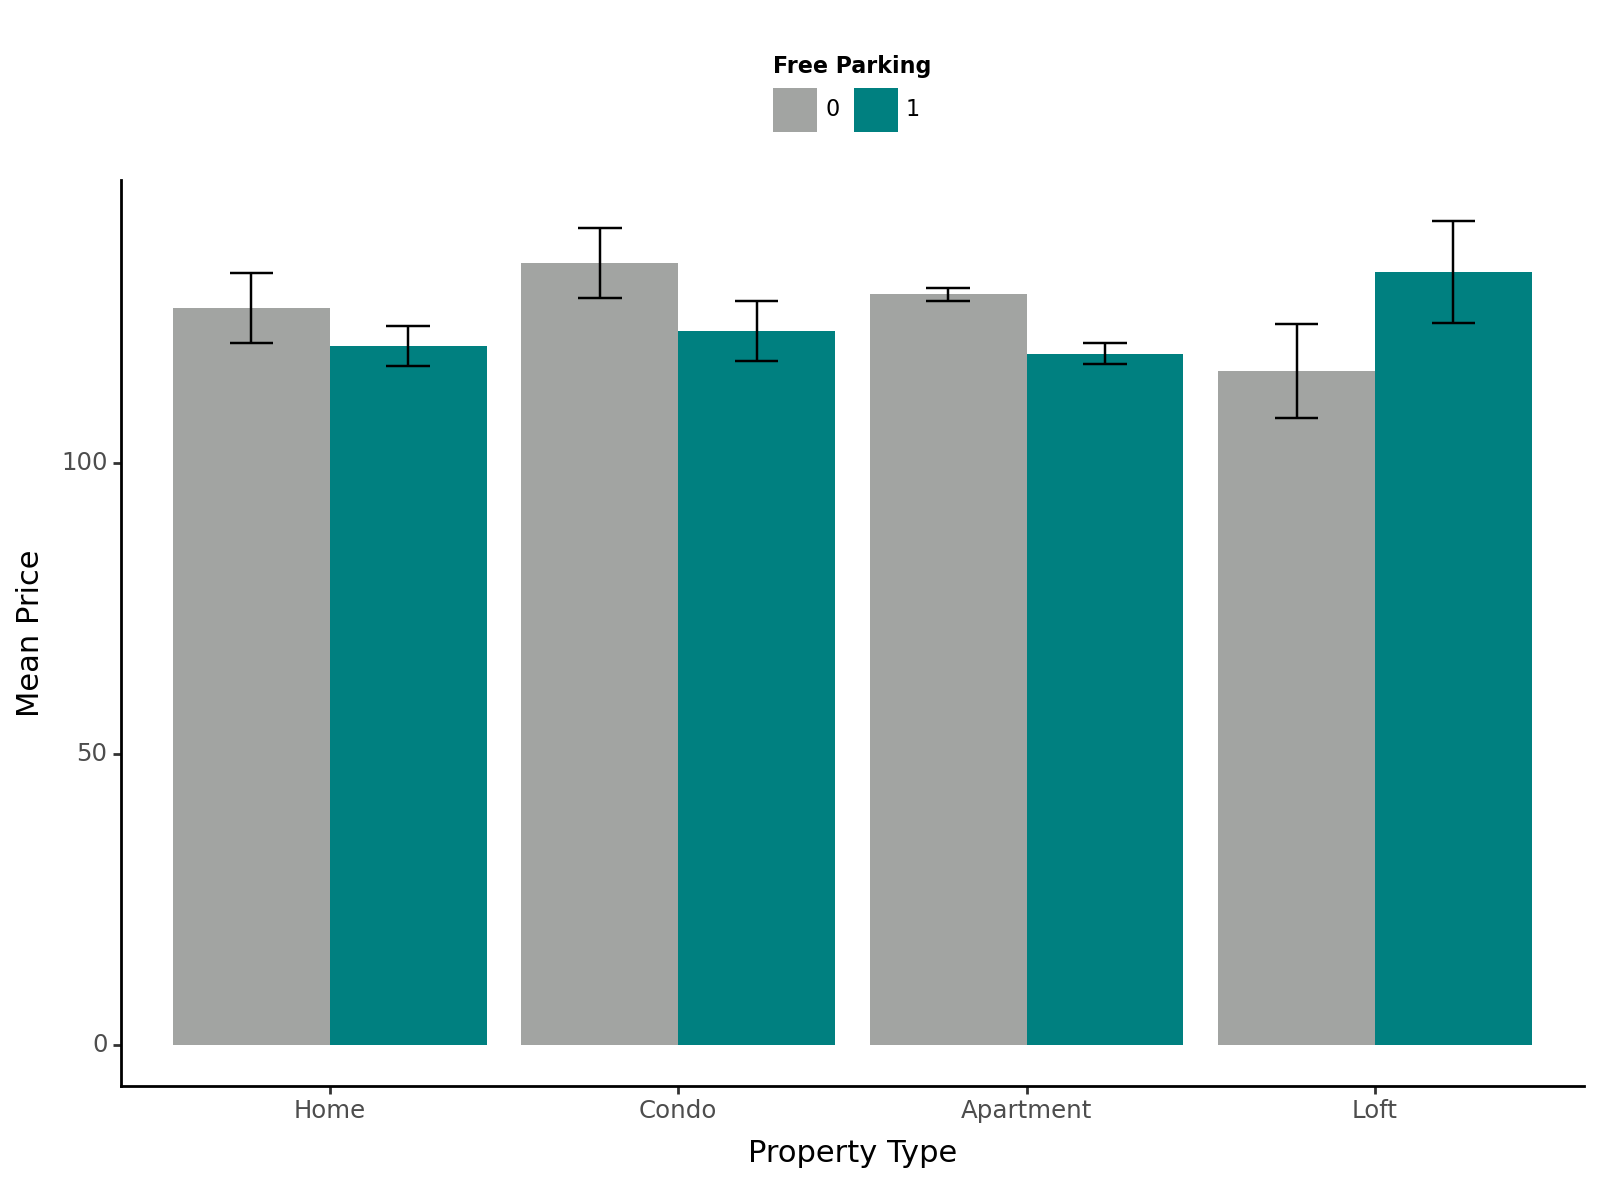

<Figure Size: (800 x 600)>

In [85]:
interactions(clean_df,"f_property_type","d_freeparking","Property Type","Free Parking")

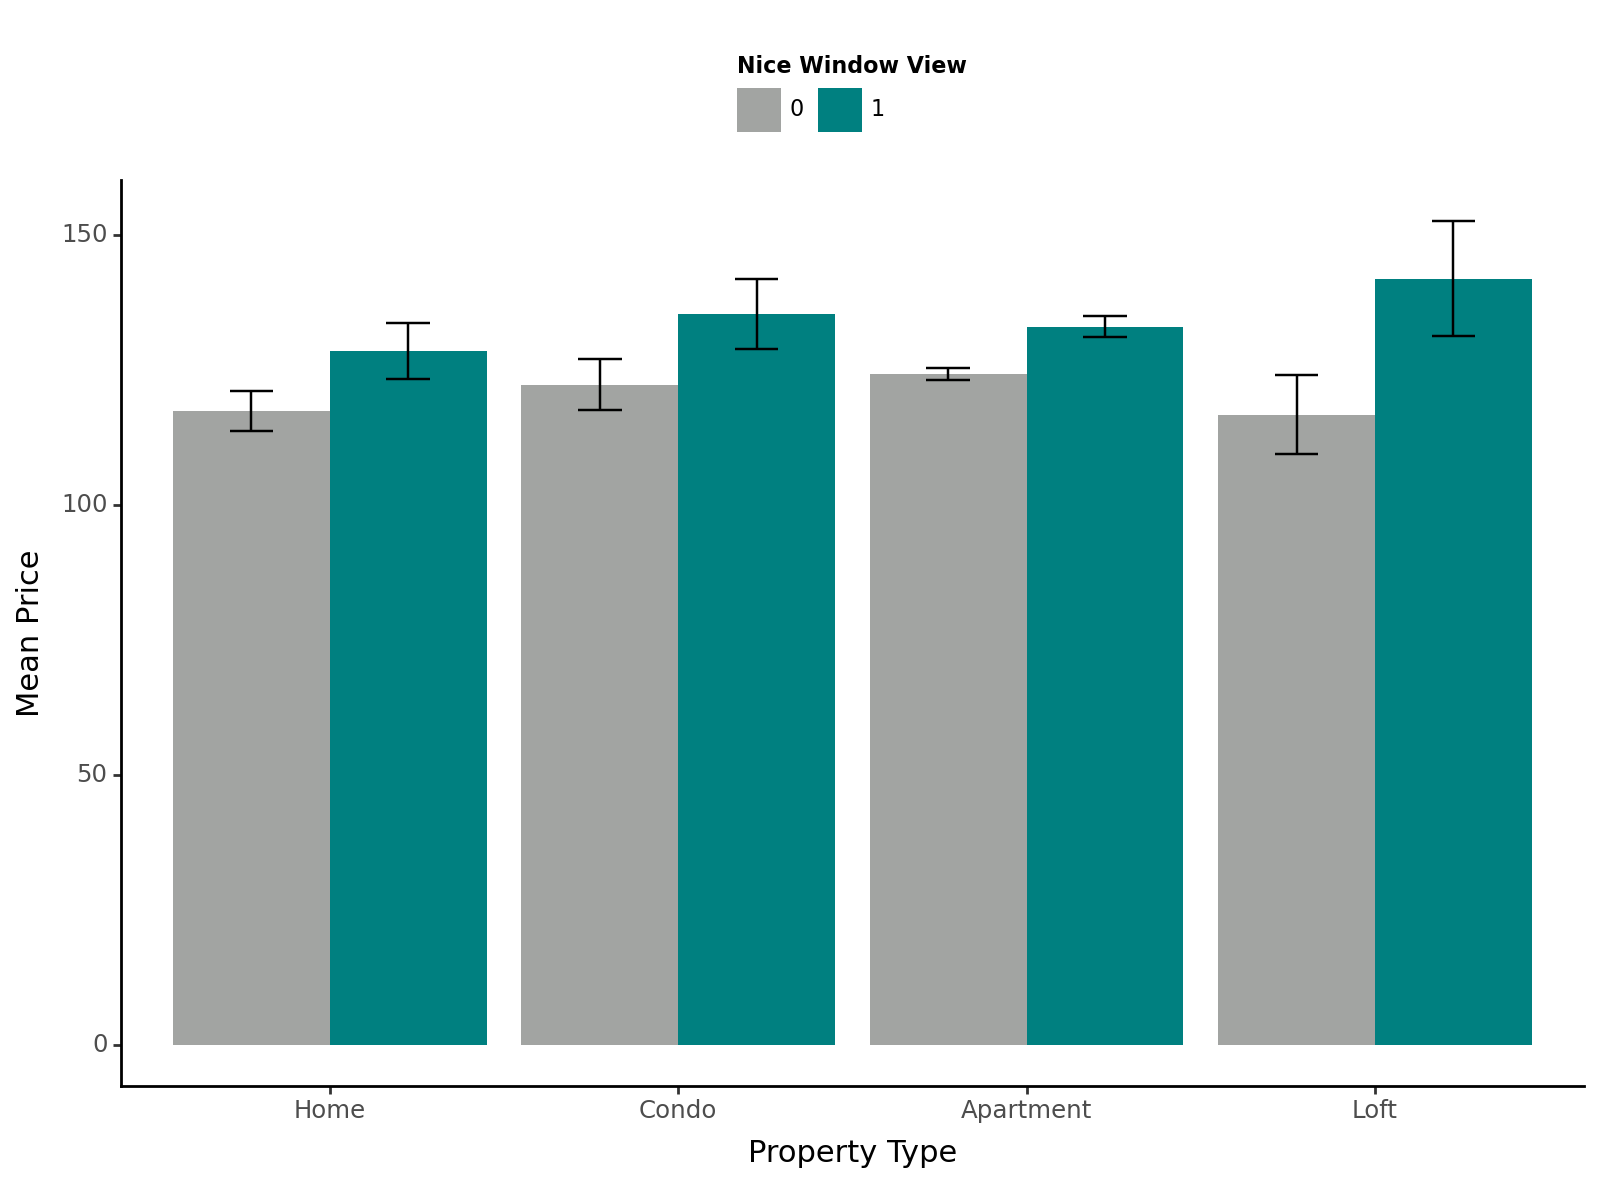

<Figure Size: (800 x 600)>

In [86]:
interactions(clean_df,"f_property_type","d_windowview","Property Type","Nice Window View")

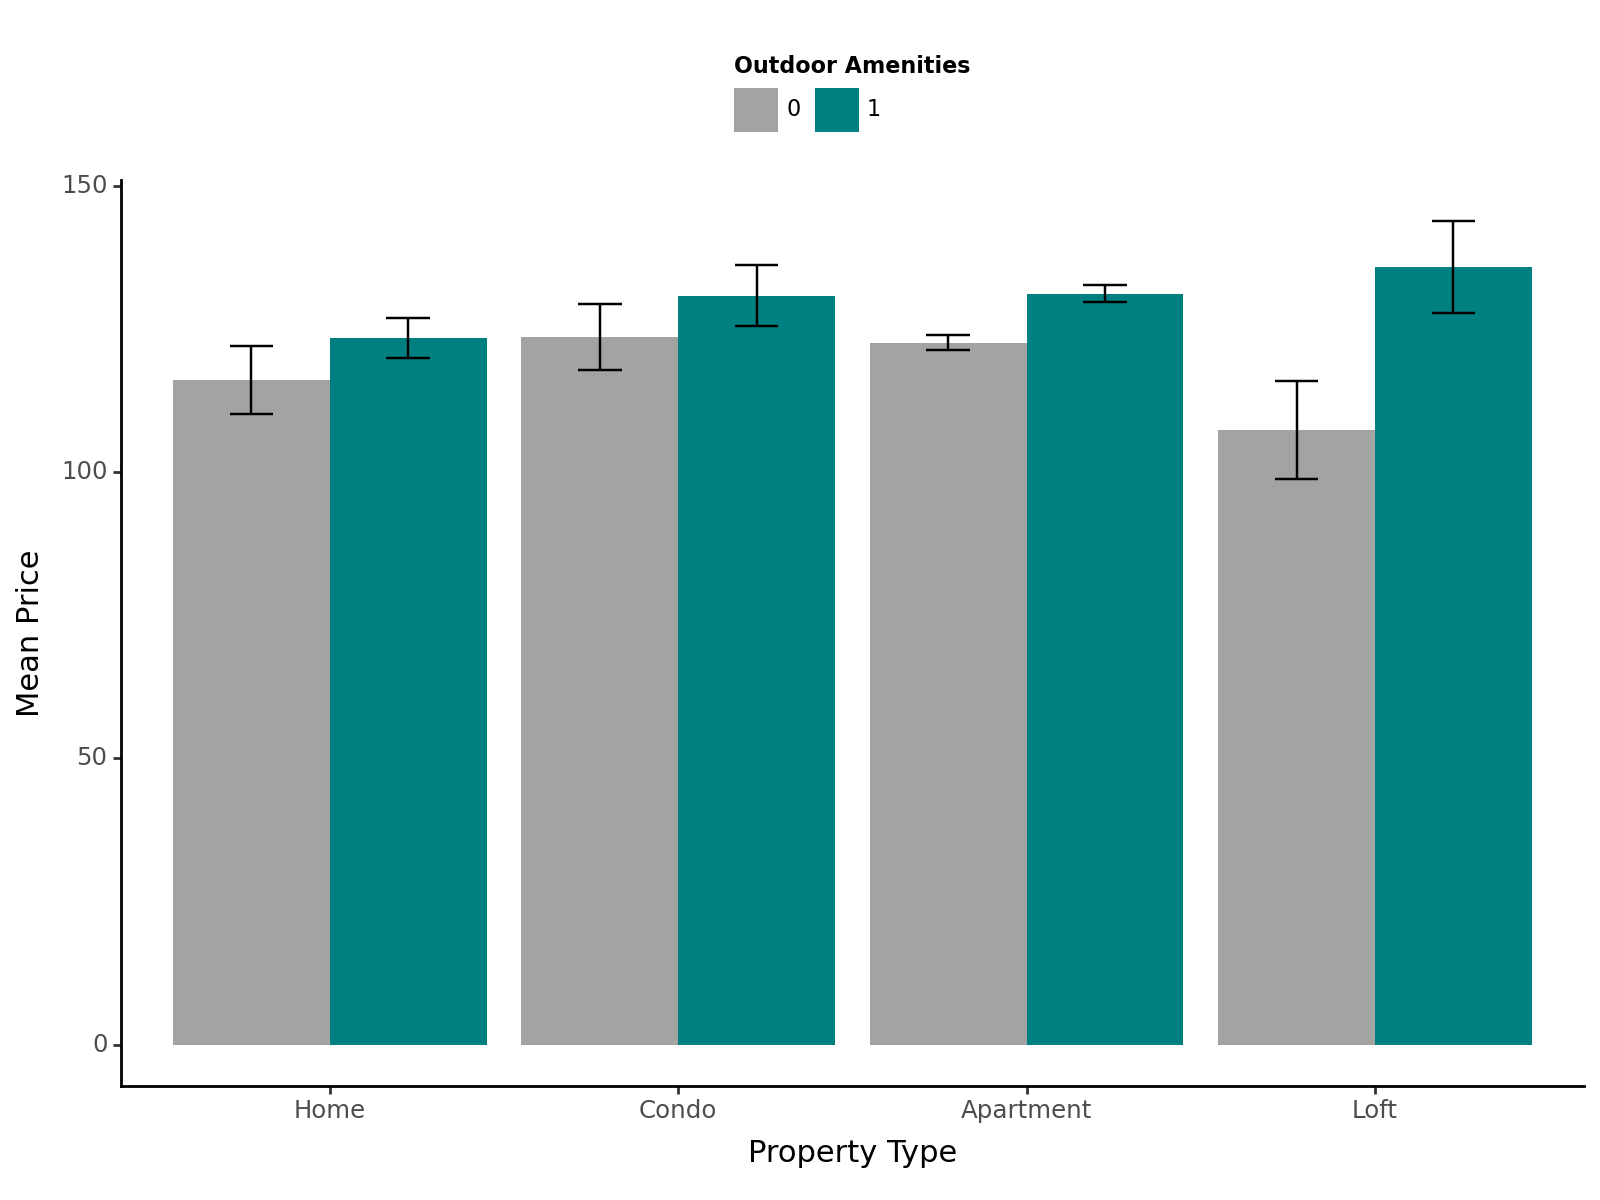

<Figure Size: (800 x 600)>

In [87]:
interactions(clean_df,"f_property_type","d_outdooramenities","Property Type","Outdoor Amenities")

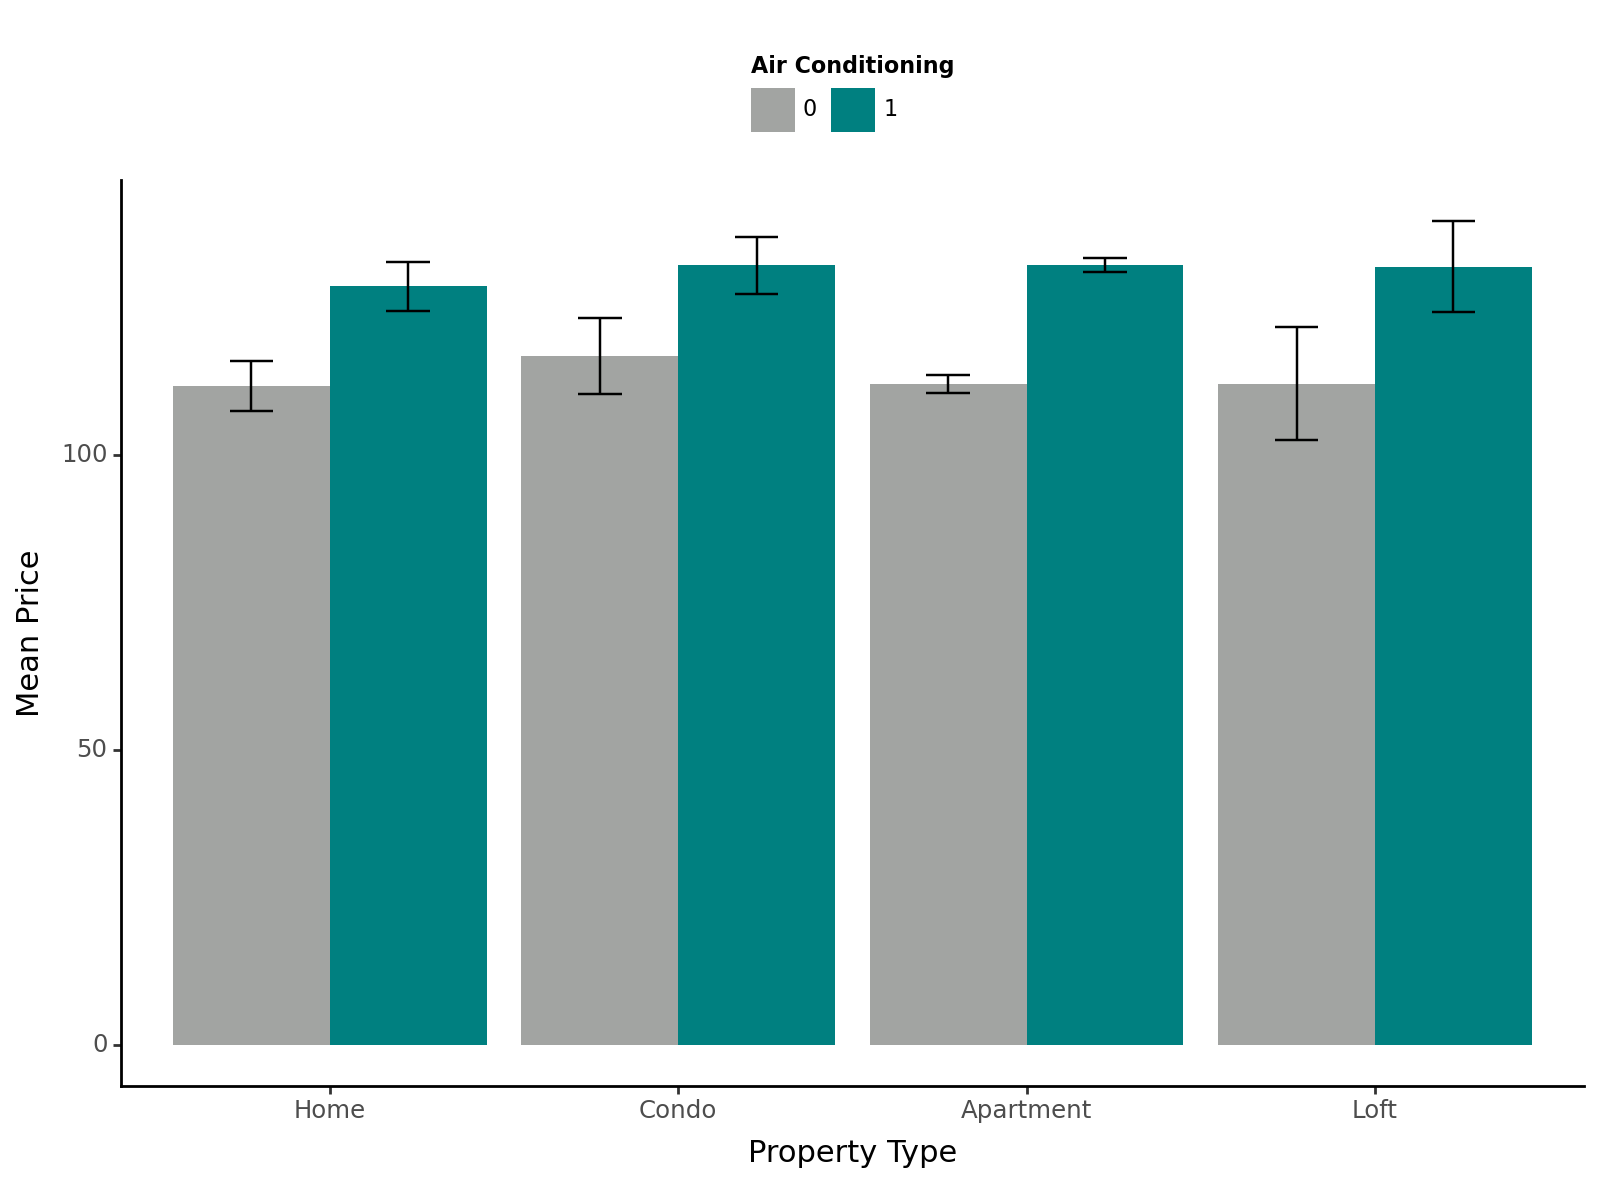

<Figure Size: (800 x 600)>

In [88]:
interactions(clean_df,"f_property_type","d_airconditioning","Property Type","Air Conditioning")

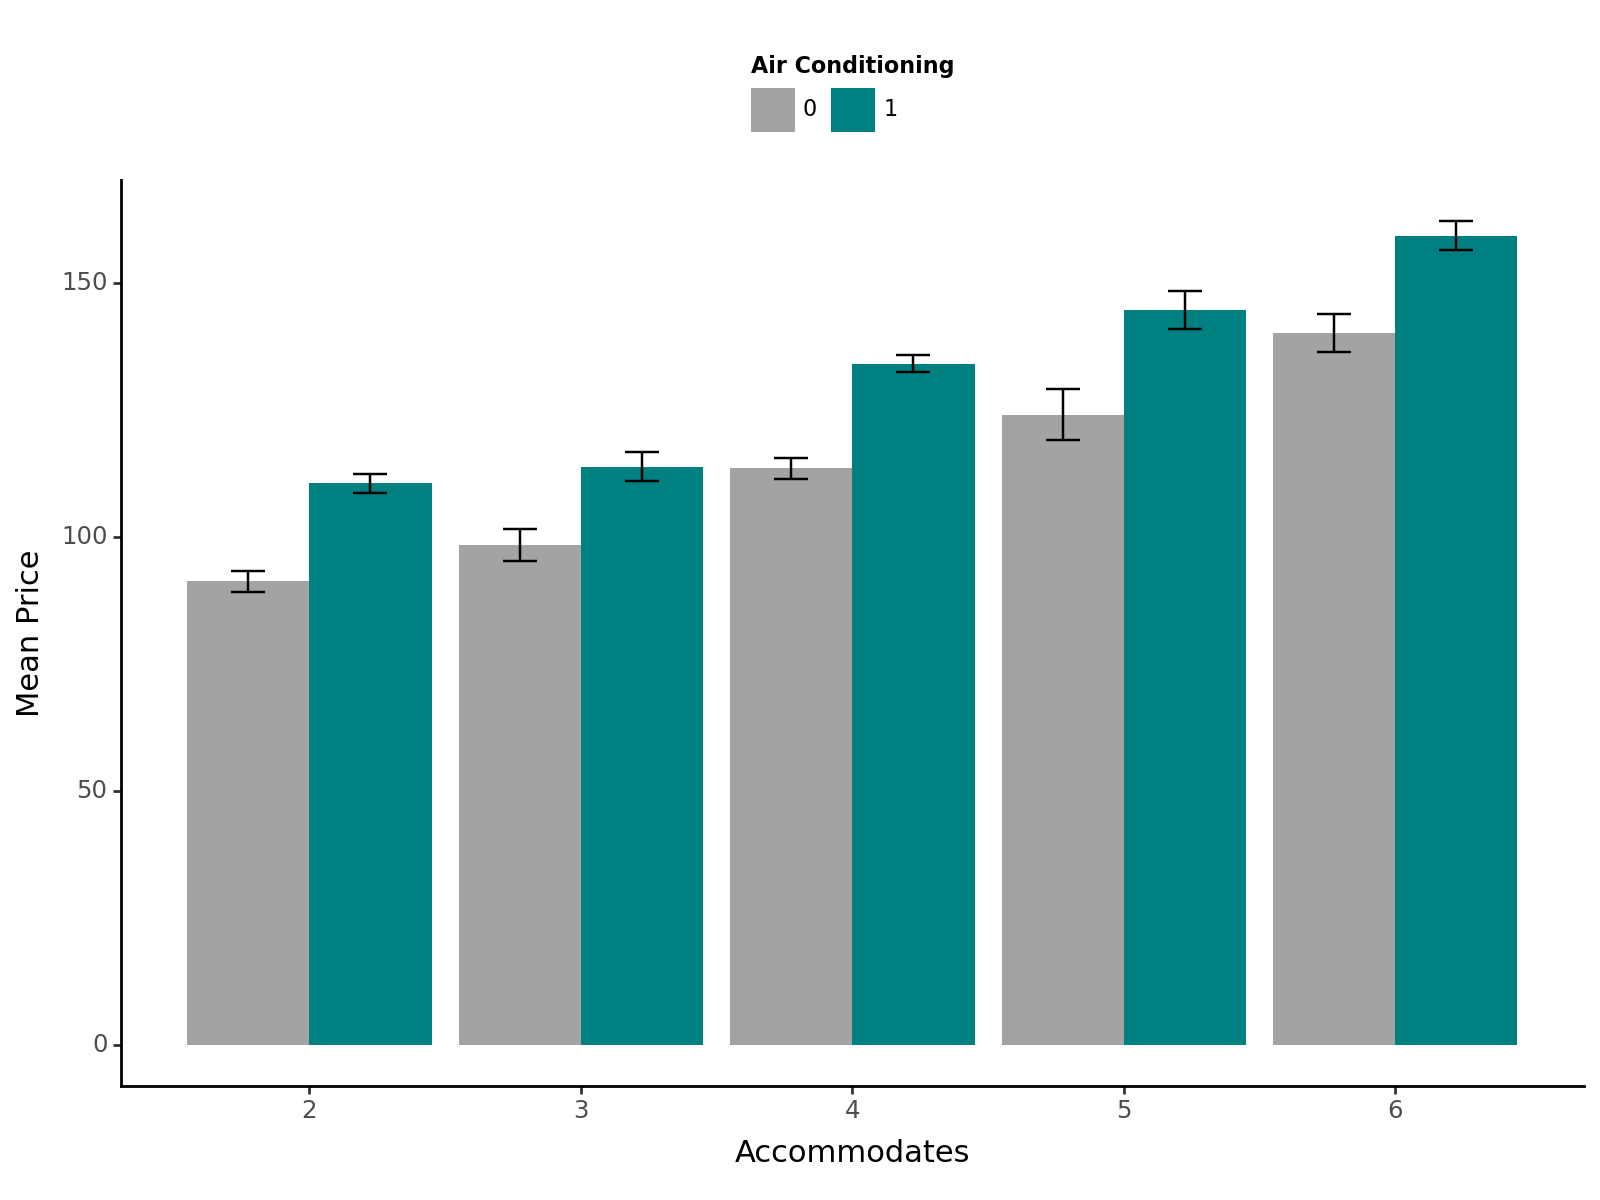

<Figure Size: (800 x 600)>

In [89]:
interactions(clean_df,"n_accommodates","d_airconditioning","Accommodates","Air Conditioning")

# Modelling
1. Random Forest
2. LASSO 
3. OLS
4. CART
5. GBM

<b>*Splitting our data into train and test data with a split of 70/30*<br>


In [90]:
data_train, data_holdout = train_test_split(clean_df, train_size=0.7, random_state=42)
data_train.shape, data_holdout.shape

((8220, 63), (3523, 63))

## 1. Random Forest

In [91]:
y, X = dmatrices("price ~ " + " + ".join(predictors), data_train)

In [92]:
print('The theoretical recommended number of variables: {:.2f}.'.format(math.sqrt(len(X.design_info.column_names))))

The theoretical recommended number of variables: 13.19.


In [93]:
rfr = RandomForestRegressor(random_state=20240210)

In [94]:
# for the max_features, I have given a range of 10-16 (13 +- 3)

tune_grid = {"max_features": [10, 12, 14, 16], "min_samples_leaf": [5, 10, 15]}

In [95]:
rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

In [96]:
%%time
rf_model = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_features=10, min_samples_leaf=5;, score=-40.873 total time=   0.8s
[CV 2/5] END max_features=10, min_samples_leaf=5;, score=-41.499 total time=   0.8s
[CV 3/5] END max_features=10, min_samples_leaf=5;, score=-39.384 total time=   0.8s
[CV 4/5] END max_features=10, min_samples_leaf=5;, score=-40.522 total time=   1.0s
[CV 5/5] END max_features=10, min_samples_leaf=5;, score=-40.620 total time=   0.9s
[CV 1/5] END max_features=10, min_samples_leaf=10;, score=-41.556 total time=   0.7s
[CV 2/5] END max_features=10, min_samples_leaf=10;, score=-42.150 total time=   0.7s
[CV 3/5] END max_features=10, min_samples_leaf=10;, score=-40.120 total time=   0.7s
[CV 4/5] END max_features=10, min_samples_leaf=10;, score=-41.149 total time=   0.6s
[CV 5/5] END max_features=10, min_samples_leaf=10;, score=-41.316 total time=   0.6s
[CV 1/5] END max_features=10, min_samples_leaf=15;, score=-41.994 total time=   0.6s
[CV 2/5] 

In [97]:
df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]

In [98]:
df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']

In [99]:
df_rf_model_cv_results

,max features,min node size,RMSE
0,10,5,-40.579618
1,10,10,-41.258527
2,10,15,-41.702295
3,12,5,-40.113479
4,12,10,-40.873274
5,12,15,-41.280858
6,14,5,-39.847604
7,14,10,-40.557287
8,14,15,-41.009283
9,16,5,-39.614088


In [100]:
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1

min node size,5,10,15
max features,,,
10,40.58,41.26,41.70
12,40.11,40.87,41.28
14,39.85,40.56,41.01
16,39.61,40.37,40.77


In [101]:
rf_rmse = rf_model.best_score_*-1
rf_rmse.round(3)

39.614

In [102]:
rf_model.best_params_

{'max_features': 16, 'min_samples_leaf': 5}

In [103]:
rf_model.best_estimator_

RandomForestRegressor(max_features=16, min_samples_leaf=5,
                      random_state=20240210)

## 2. LASSO

In [106]:
lasso_model =  ElasticNet(l1_ratio = 1, fit_intercept = True)

In [107]:
lasso_model_cv = GridSearchCV(
    lasso_model,
    {"alpha":[i/100 for i in range(5, 26, 5)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)


In [108]:
y, X = dmatrices("price ~ " + " + ".join(coefficients_df['Feature']), data_train)

In [109]:
%%time
lasso_model_cv.fit(X, y.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ......................alpha=0.05;, score=-38.952 total time=   0.2s
[CV 2/5] END ......................alpha=0.05;, score=-39.018 total time=   0.4s
[CV 3/5] END ......................alpha=0.05;, score=-37.247 total time=   0.9s
[CV 4/5] END ......................alpha=0.05;, score=-39.475 total time=   0.7s
[CV 5/5] END ......................alpha=0.05;, score=-39.008 total time=   0.3s
[CV 1/5] END .......................alpha=0.1;, score=-38.977 total time=   0.1s
[CV 2/5] END .......................alpha=0.1;, score=-39.153 total time=   0.2s
[CV 3/5] END .......................alpha=0.1;, score=-37.316 total time=   0.3s
[CV 4/5] END .......................alpha=0.1;, score=-39.577 total time=   0.3s
[CV 5/5] END .......................alpha=0.1;, score=-39.201 total time=   0.2s
[CV 1/5] END ......................alpha=0.15;, score=-39.031 total time=   0.1s
[CV 2/5] END ......................alpha=0.15;, s

GridSearchCV(cv=5, estimator=ElasticNet(l1_ratio=1),
             param_grid={'alpha': [0.05, 0.1, 0.15, 0.2, 0.25]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [110]:
pd.DataFrame(
    lasso_model_cv.best_estimator_.coef_.tolist(),
    index=X.design_info.column_names,
    columns=["lasso_coefficient"],
).assign(lasso_coefficient=lambda x: x.lasso_coefficient.round(3)).loc[
    lambda x: x.lasso_coefficient != 0
]

,lasso_coefficient
f_neighbourhood_cleansed[T.Ajuda],-1.364
f_neighbourhood_cleansed[T.Alcntara],2.749
f_neighbourhood_cleansed[T.Arroios],11.584
f_neighbourhood_cleansed[T.Avenidas Novas],4.762
f_neighbourhood_cleansed[T.Belm],0.135
...,...
n_accommodates:d_kidfriendly,0.127
n_accommodates:d_cabletv,1.232
n_accommodates:d_paidparking,2.139
n_accommodates:d_tv,1.881


In [111]:
lasso_model_cv.best_estimator_

ElasticNet(alpha=0.05, l1_ratio=1)

In [112]:
lasso_model_cv.cv_results_

{'mean_fit_time': array([0.60444632, 0.3087584 , 0.22319584, 0.17509995, 0.15171003]),
 'std_fit_time': array([0.25368317, 0.0639107 , 0.03753247, 0.01821044, 0.01143315]),
 'mean_score_time': array([0.00231605, 0.00282145, 0.00241261, 0.00254221, 0.00152102]),
 'std_score_time': array([0.00163286, 0.00070765, 0.00057161, 0.00060172, 0.00090518]),
 'param_alpha': masked_array(data=[0.05, 0.1, 0.15, 0.2, 0.25],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.05},
  {'alpha': 0.1},
  {'alpha': 0.15},
  {'alpha': 0.2},
  {'alpha': 0.25}],
 'split0_test_score': array([-38.95154952, -38.97711619, -39.0309648 , -39.16470712,
        -39.28231487]),
 'split1_test_score': array([-39.01768049, -39.15252366, -39.32464222, -39.50667432,
        -39.6661578 ]),
 'split2_test_score': array([-37.24715737, -37.31607234, -37.4400269 , -37.61352884,
        -37.78900151]),
 'split3_test_score': array([-39.47482277, -39.

In [113]:
lasso_rmse = pd.DataFrame(lasso_model_cv.cv_results_).loc[
    lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha
].mean_test_score.values[0] * -1
lasso_rmse

38.73976796107056

## 3. OLS


In [116]:
y, X = dmatrices("price ~ " + " + ".join(coefficients_df['Feature']), data_train)

ols_model = LinearRegression().fit(X,y)

#y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_2), data_holdout)

y_hat = ols_model.predict(X)

ols_rmse = mean_squared_error(y,y_hat,squared=False)
ols_rmse

37.49618568883557

In [117]:
ols_model_coeffs_df = pd.DataFrame(
    ols_model.coef_.tolist()[0],
    index=X.design_info.column_names,
    columns=["ols_coefficient"],
).assign(ols_coefficient=lambda x: x.ols_coefficient.round(3))

In [118]:
ols_model_coeffs_df

,ols_coefficient
Intercept,-4.904817e+04
f_property_type[T.Condo],-4.060000e+00
f_property_type[T.Apartment],-3.638000e+00
f_property_type[T.Loft],-1.327400e+01
f_neighbourhood_cleansed[T.Abrigada e Cabanas de Torres],4.468437e+10
...,...
n_accommodates:d_cabletv,7.570000e-01
n_accommodates:d_paidparking,2.525000e+00
n_accommodates:d_soundsystem,-3.200000e+00
n_accommodates:d_tv,1.524000e+00


## 4. CART

In [127]:
y, X = dmatrices("price ~ " + " + ".join(coefficients_df['Feature']), data_train)
cart_model = DecisionTreeRegressor(random_state=20240210)

In [128]:
path = cart_model.cost_complexity_pruning_path(X, y.ravel())
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [129]:
ccp_alphas

array([0.00000000e+00, 6.08272506e-05, 6.08272506e-05, ...,
       3.05793870e+01, 8.42914682e+01, 2.91912794e+02])

In [130]:
ccp_aplhas_filtered = [x for x in ccp_alphas if x > 2]

In [131]:
%%time

cart_model_cv = RandomizedSearchCV(
    cart_model,
    {"ccp_alpha":ccp_aplhas_filtered},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)
cart_model_cv.fit(X,y.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .....ccp_alpha=2.739627274514433;, score=-43.772 total time=   0.5s
[CV 2/5] END .....ccp_alpha=2.739627274514433;, score=-43.940 total time=   0.7s
[CV 3/5] END .....ccp_alpha=2.739627274514433;, score=-42.588 total time=   0.5s
[CV 4/5] END .....ccp_alpha=2.739627274514433;, score=-43.623 total time=   0.5s
[CV 5/5] END .....ccp_alpha=2.739627274514433;, score=-42.747 total time=   0.5s
[CV 1/5] END ....ccp_alpha=2.5975824092442465;, score=-43.792 total time=   0.5s
[CV 2/5] END ....ccp_alpha=2.5975824092442465;, score=-43.916 total time=   0.5s
[CV 3/5] END ....ccp_alpha=2.5975824092442465;, score=-42.892 total time=   0.5s
[CV 4/5] END ....ccp_alpha=2.5975824092442465;, score=-43.745 total time=   0.5s
[CV 5/5] END ....ccp_alpha=2.5975824092442465;, score=-42.815 total time=   0.5s
[CV 1/5] END .....ccp_alpha=8.632071755802087;, score=-42.749 total time=   0.5s
[CV 2/5] END .....ccp_alpha=8.632071755802087;, 

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=20240210),
                   param_distributions={'ccp_alpha': [2.012884887551582,
                                                      2.033172831959657,
                                                      2.0624492453038243,
                                                      2.0674906804468236,
                                                      2.0799737513933154,
                                                      2.0849222799046756,
                                                      2.088938457762435,
                                                      2.0900092975314397,
                                                      2.1238979983187036,
                                                      2.1301488135380264,
                                                      2.1482172328887748,
                                                      2.1605875295727017,
                                                      2.1698438767...
                                                      2.1742199897326735,
                                                      2.1956206905610527,
                                                      2.2151807813394235,
                                                      2.217609163646671,
                                                      2.2193557347012187,
                                                      2.2239767504730983,
                                                      2.2315261524994217,
                                                      2.2337256690997576,
                                                      2.2413334742816,
                                                      2.2474137883052427,
                                                      2.2533029197080245,
                                                      2.257009058949553,
                                                      2.274321273383066,
                                                      2.2847980596803197,
                                                      2.312499352267949,
                                                      2.312973449907794, ...]},
                   scoring='neg_root_mean_squared_error', verbose=3)

In [132]:
cart_rmse = pd.DataFrame(cart_model_cv.cv_results_).loc[
    lambda x: x.param_ccp_alpha == cart_model_cv.best_estimator_.ccp_alpha
].mean_test_score.values[0] * -1
cart_rmse

42.87014299796745

In [133]:
cart_model_cv.best_estimator_

DecisionTreeRegressor(ccp_alpha=7.757956469871544, random_state=20240210)

## 4. GBM Simple


In [136]:
gbm = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=20, max_features = 10
                                #, n_estimators = 50
                               )

tune_grid = {"n_estimators": [200, 300], "max_depth": [5, 10]}

gbm_model_cv = GridSearchCV(
    gbm,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
    n_jobs=-1
)

In [137]:
categorical_columns = [col for col in predictors if col.startswith("f_")]
numerical_columns = [col for col in predictors if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose=True
)

In [138]:
%%time
gbm_pipe.fit(data_train[predictors],data_train.price)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Pipeline] ......... (step 2 of 2) Processing regressor, total=  22.5s
CPU times: total: 2.86 s
Wall time: 22.6 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_neighbourhood_cleansed']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates',
                                                   'n_bedrooms', 'n_bathrooms',
                                                   'n_beds',
                                                   'n_number_of_reviews',
                                                   'n_review_scores_rating',
                                                   'd_host_is_superhost',
                                                   'd_instant_bookable',
                                                   'd_workspace',
                                                   'd_aircondition...
                                                   'd_fireextinguisher',
                                                   'd_hottub', 'd_dishwasher',
                                                   'd_wifi', 'd_keypad',
                                                   'd_kidfriendly', 'd_shampoo',
                                                   'd_cabletv', 'd_paidparking', ...])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=GradientBoostingRegressor(max_features=10,
                                                                  min_samples_split=20),
                              n_jobs=-1,
                              param_grid={'max_depth': [5, 10],
                                          'n_estimators': [200, 300]},
                              scoring='neg_root_mean_squared_error',
                              verbose=10))],
         verbose=True)

In [139]:
gbm_model_cv.cv_results_

{'mean_fit_time': array([2.6240078 , 4.66205959, 6.42044363, 6.73691583]),
 'std_fit_time': array([0.17359115, 0.51083412, 0.423384  , 0.55695836]),
 'mean_score_time': array([0.03446989, 0.0558681 , 0.07184377, 0.05206895]),
 'std_score_time': array([0.00410584, 0.00477827, 0.01697052, 0.01117227]),
 'param_max_depth': masked_array(data=[5, 5, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[200, 300, 200, 300],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 5, 'n_estimators': 200},
  {'max_depth': 5, 'n_estimators': 300},
  {'max_depth': 10, 'n_estimators': 200},
  {'max_depth': 10, 'n_estimators': 300}],
 'split0_test_score': array([-38.27682916, -37.98355358, -37.60873551, -37.30233223]),
 'split1_test_score': array([-38.01097376, -37.59455657, -37.32662852, -37.12354156]),
 'split2_test_score': array(

In [140]:
gbm_model_cv.best_estimator_

GradientBoostingRegressor(max_depth=10, max_features=10, min_samples_split=20,
                          n_estimators=300)

In [141]:
gbm_rmse = gbm_model_cv.best_score_*-1

In [148]:
gbm_rmse

36.92191026234529

#### Getting Predictions for our best model (GBM)

In [192]:
predictions_holdout = gbm_pipe.predict(data_holdout[predictors])
holdout_prices = data_holdout.price

# Feature Importance and Partial Dependance Plots

1. Individual Feature Importance

In [149]:
y, X = dmatrices("price ~ " + " + ".join(predictors), data_train)

In [150]:
rf_model.best_estimator_.feature_importances_

array([0.00000000e+00, 1.58344001e-03, 5.64540625e-03, 9.45568192e-04,
       0.00000000e+00, 0.00000000e+00, 6.57260432e-04, 1.35803963e-04,
       3.33345976e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.57289554e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.18915604e-05, 0.00000000e+00, 1.07485518e-04,
       0.00000000e+00, 3.13735581e-03, 0.00000000e+00, 0.00000000e+00,
       3.62695690e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.75617794e-04, 7.15871016e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.62452644e-04, 1.91378900e-04, 4.39815201e-04, 3.50873628e-05,
       0.00000000e+00, 0.00000000e+00, 1.35585607e-05, 9.28578783e-03,
       7.58895717e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 9.96769560e-04, 1.35371225e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [151]:
pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)

,0
Intercept,0.000000
f_property_type[T.Condo],0.001583
f_property_type[T.Apartment],0.005645
f_property_type[T.Loft],0.000946
f_neighbourhood_cleansed[T.Abrigada e Cabanas de Torres],0.000000
...,...
d_backyard,0.004828
d_gym,0.000978
d_gameconsole,0.000027
d_conditioner,0.002820


In [152]:
df_var_imp = pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()

In [153]:
df_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,n_bathrooms,10.5%,10.5%
1,n_bedrooms,9.2%,19.7%
2,n_accommodates,7.8%,27.4%
3,n_review_scores_rating,6.0%,33.4%
4,n_beds,5.4%,38.8%
5,n_number_of_reviews,5.2%,44.0%
6,d_dishwasher,4.9%,48.9%
7,d_airconditioning,3.5%,52.4%
8,f_neighbourhood_cleansed[T.Santa Maria Maior],3.3%,55.7%
9,d_elevator,2.7%,58.4%


In [154]:
# we only care for variables with an importance of more than 1 pct
cutoff = 0.01

In [155]:
graph1_df = df_var_imp[df_var_imp.imp > cutoff] 
graph1_df = graph1_df.sort_values(by='imp',ascending = False).reset_index(drop = True)
graph1_df = graph1_df.iloc[:10]

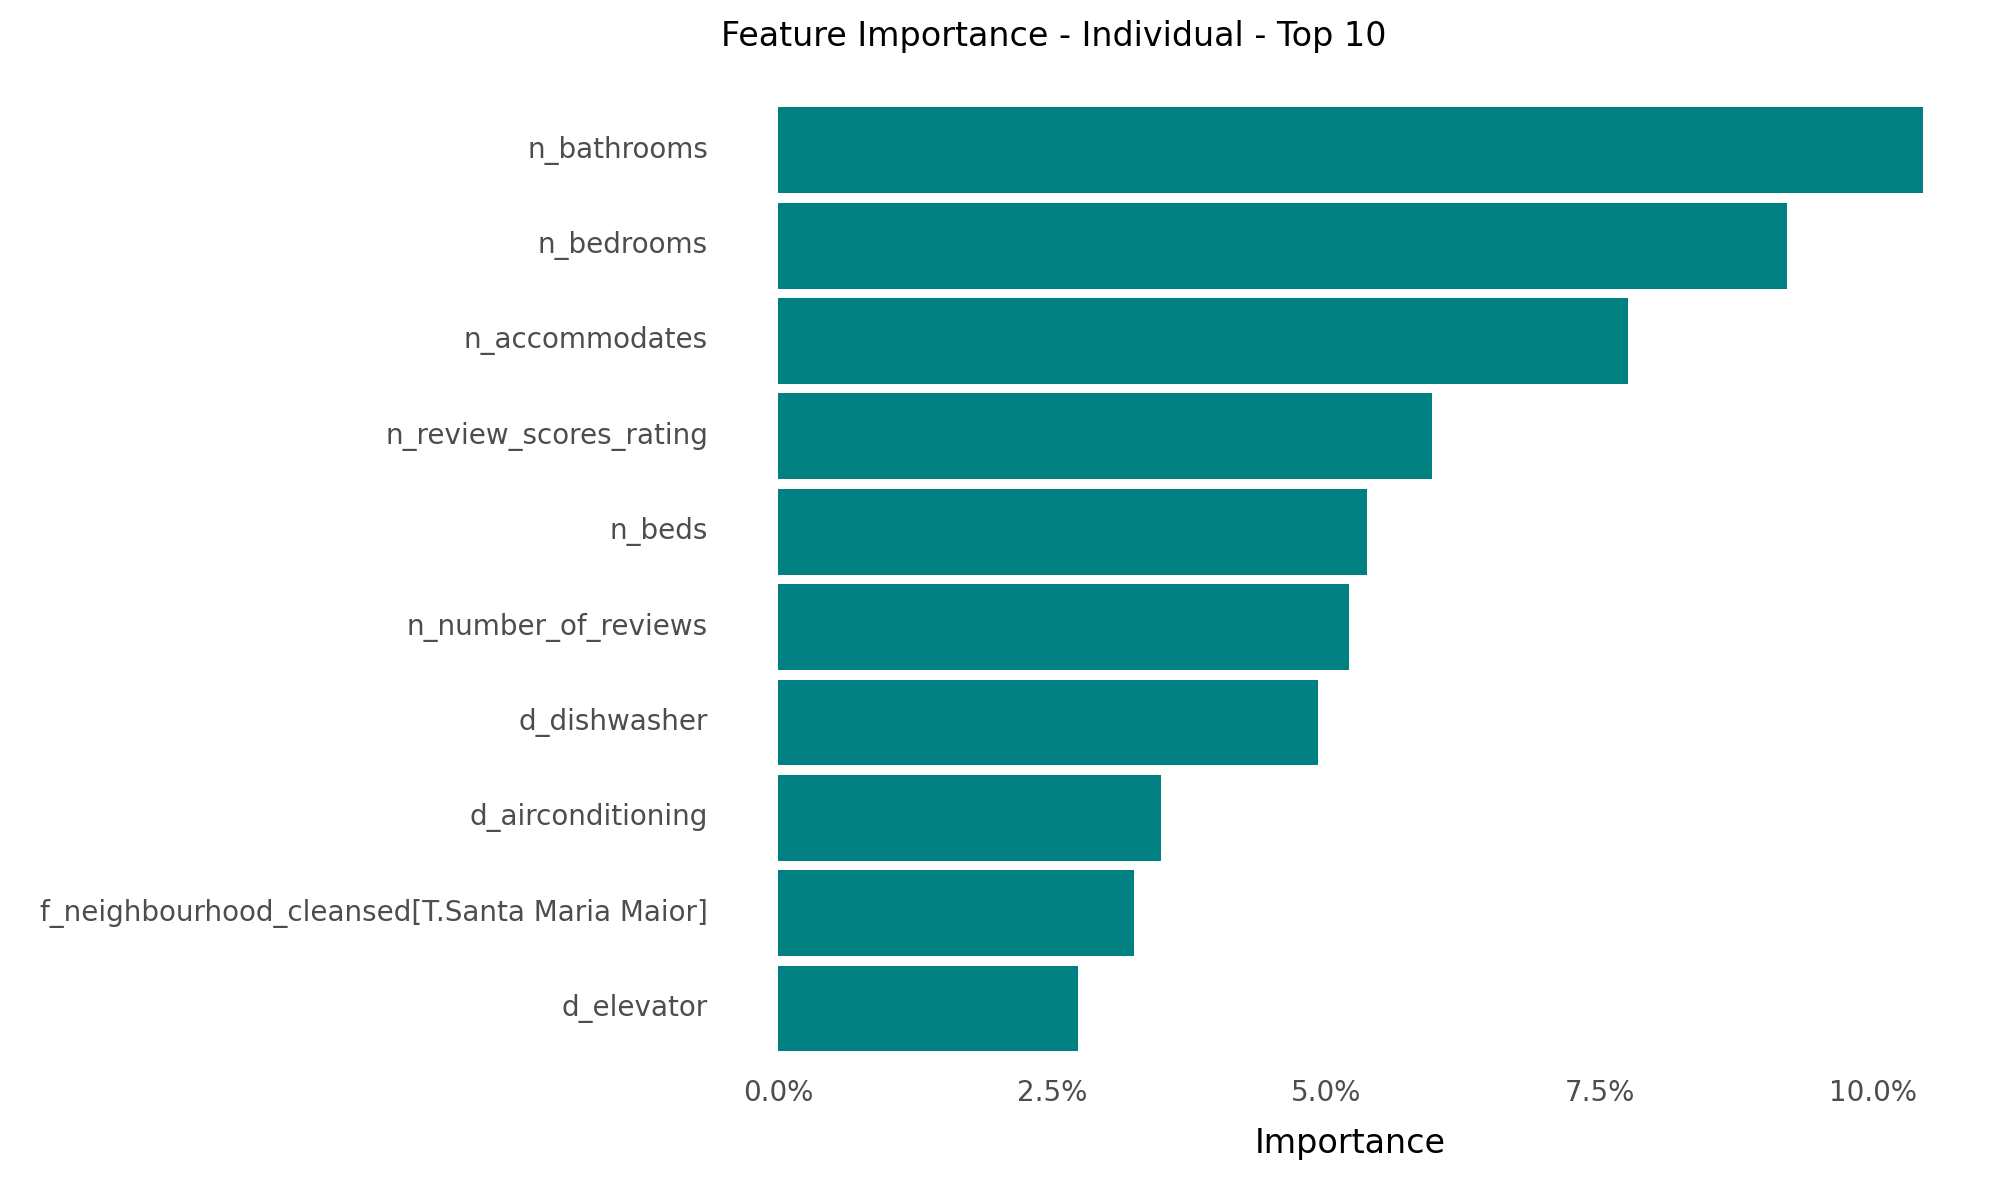

<Figure Size: (1000 x 600)>

In [156]:
(
    ggplot(graph1_df, aes(x='reorder(variable,imp)', y='imp')) +
    geom_bar(stat='identity', fill='#008080') +
    coord_flip() + theme_minimal() +
    labs(x='',y='Importance', title='Feature Importance - Individual - Top 10') +
    theme(panel_grid_major=element_blank(), panel_grid_minor=element_blank(), 
         plot_title=element_text(size=12), axis_text=element_text(size=10), axis_title=element_text(size=12), 
         figure_size=(10, 6)) + 
    scale_y_continuous(labels=percent_format())
)

In [157]:
categorical_columns = [col for col in predictors if col.startswith("f_")]
numerical_columns = [col for col in predictors if col not in categorical_columns]

In [158]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer([
    ("cat", categorical_encoder, categorical_columns),
    ("num", "passthrough", numerical_columns)])

rf_pipeline = Pipeline(
    [("preprocess", preprocessing), 
     ("regressor", rf_model.best_estimator_)] # put best model to pipeline
)

In [159]:
%%time
rf_pipeline.fit(data_train[predictors],data_train.price)

CPU times: total: 1.28 s
Wall time: 1.49 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_neighbourhood_cleansed']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates',
                                                   'n_bedrooms', 'n_bathrooms',
                                                   'n_beds',
                                                   'n_number_of_reviews',
                                                   'n_review_scores_rating',
                                                   'd_host_is_superhost',
                                                   'd_instant_bookable',
                                                   'd_workspace',
                                                   'd_aircondition...
                                                   'd_firstaidkit',
                                                   'd_luxuryamenities', 'd_bbq',
                                                   'd_windowview',
                                                   'd_essentials', 'd_hangers',
                                                   'd_securitycameras',
                                                   'd_privateentrance',
                                                   'd_washer',
                                                   'd_fireextinguisher',
                                                   'd_hottub', 'd_dishwasher',
                                                   'd_wifi', 'd_keypad',
                                                   'd_kidfriendly', 'd_shampoo',
                                                   'd_cabletv', 'd_paidparking', ...])])),
                ('regressor',
                 RandomForestRegressor(max_features=16, min_samples_leaf=5,
                                       random_state=20240210))])

In [160]:
%%time
result = permutation_importance(
    rf_pipeline,
    data_holdout[predictors],
    data_holdout.price,
    n_repeats=10,
    random_state=45,
)

CPU times: total: 45.2 s
Wall time: 48.9 s


In [161]:
grouped = [
    "f_property_type",
    "n_bathrooms",
    "n_accommodates",
    "n_beds",
    "f_neighbourhood_cleansed"
]

In [162]:
df_grouped_var_imp = pd.DataFrame(
        result.importances_mean,
        data_train[predictors].columns)\
    .loc[grouped]\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)
df_grouped_var_imp['cumulative_imp'] = df_grouped_var_imp.imp.cumsum()

In [163]:
df_grouped_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,n_bathrooms,7.0%,7.0%
1,f_neighbourhood_cleansed,4.4%,11.4%
2,n_accommodates,3.7%,15.1%
3,n_beds,1.5%,16.5%
4,f_property_type,0.3%,16.8%


In [164]:
df_clean_varimp = pd.DataFrame(
        result.importances_mean,
        data_train[predictors].columns)\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)

df_clean_varimp['cumulative_imp'] = df_var_imp['imp'].cumsum()
df_clean_varimp[df_clean_varimp.cumulative_imp < 0.91]

,variable,imp,cumulative_imp
0,n_bathrooms,0.069704,0.104525
1,f_neighbourhood_cleansed,0.044419,0.196612
2,n_bedrooms,0.041965,0.274237
3,n_accommodates,0.036560,0.333949
4,d_dishwasher,0.035169,0.387712
5,d_airconditioning,0.022028,0.439833
6,d_freeparking,0.021548,0.489156
7,d_elevator,0.016076,0.524106
8,n_review_scores_rating,0.015457,0.556611
9,n_beds,0.014663,0.583952


In [165]:
graph2_df = df_clean_varimp.iloc[0:10]
graph2_df = graph2_df.sort_values(by='imp',ascending = False).reset_index(drop = True)
graph2_df

,variable,imp,cumulative_imp
0,n_bathrooms,0.069704,0.104525
1,f_neighbourhood_cleansed,0.044419,0.196612
2,n_bedrooms,0.041965,0.274237
3,n_accommodates,0.036560,0.333949
4,d_dishwasher,0.035169,0.387712
5,d_airconditioning,0.022028,0.439833
6,d_freeparking,0.021548,0.489156
7,d_elevator,0.016076,0.524106
8,n_review_scores_rating,0.015457,0.556611
9,n_beds,0.014663,0.583952


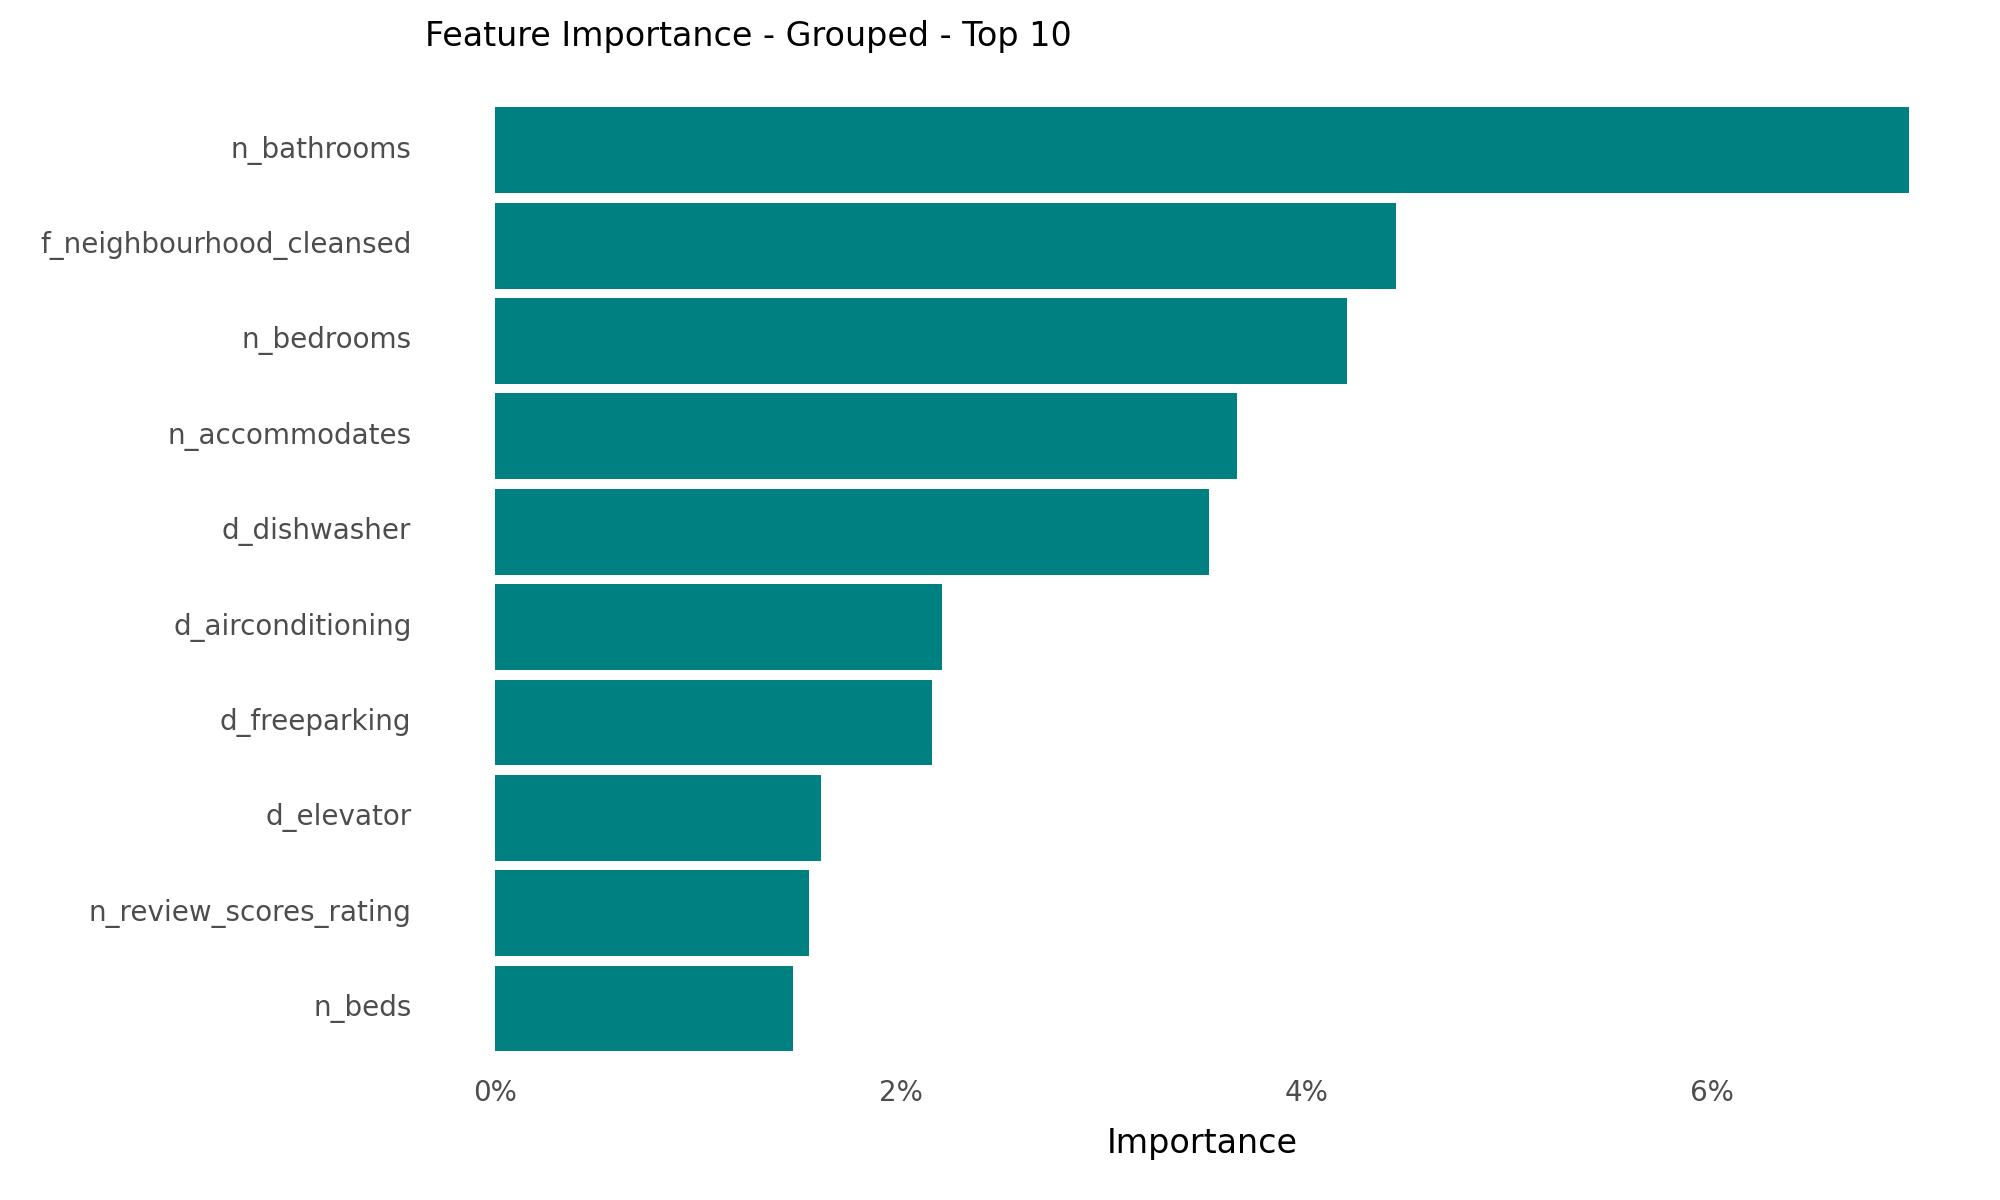

<Figure Size: (1000 x 600)>

In [166]:
(
    ggplot(graph2_df, aes(x='reorder(variable,imp)', y='imp')) +
    geom_bar(stat='identity', fill='#008080') +
    coord_flip() + theme_minimal() +
    labs(x='',y='Importance', title='Feature Importance - Grouped - Top 10') +
    theme(panel_grid_major=element_blank(), panel_grid_minor=element_blank(), 
         plot_title=element_text(size=12), axis_text=element_text(size=10), axis_title=element_text(size=12), 
         figure_size=(10, 6)) + 
    scale_y_continuous(labels=percent_format())
)

### Partial Dependance Plots

In [167]:
accomodates_pdp = partial_dependence(
    rf_pipeline, data_holdout[predictors], ["n_accommodates"], kind="average"
)

In [168]:
graph3_df = pd.DataFrame(
    {'Accommodates': accomodates_pdp['values'][0], 
     'Average Price': accomodates_pdp['average'][0]}
    ).sort_values(by = 'Average Price')

graph3_df

,Accommodates,Average Price
0,2,119.018562
1,3,119.787857
2,4,126.609278
3,5,128.142939
4,6,131.370756


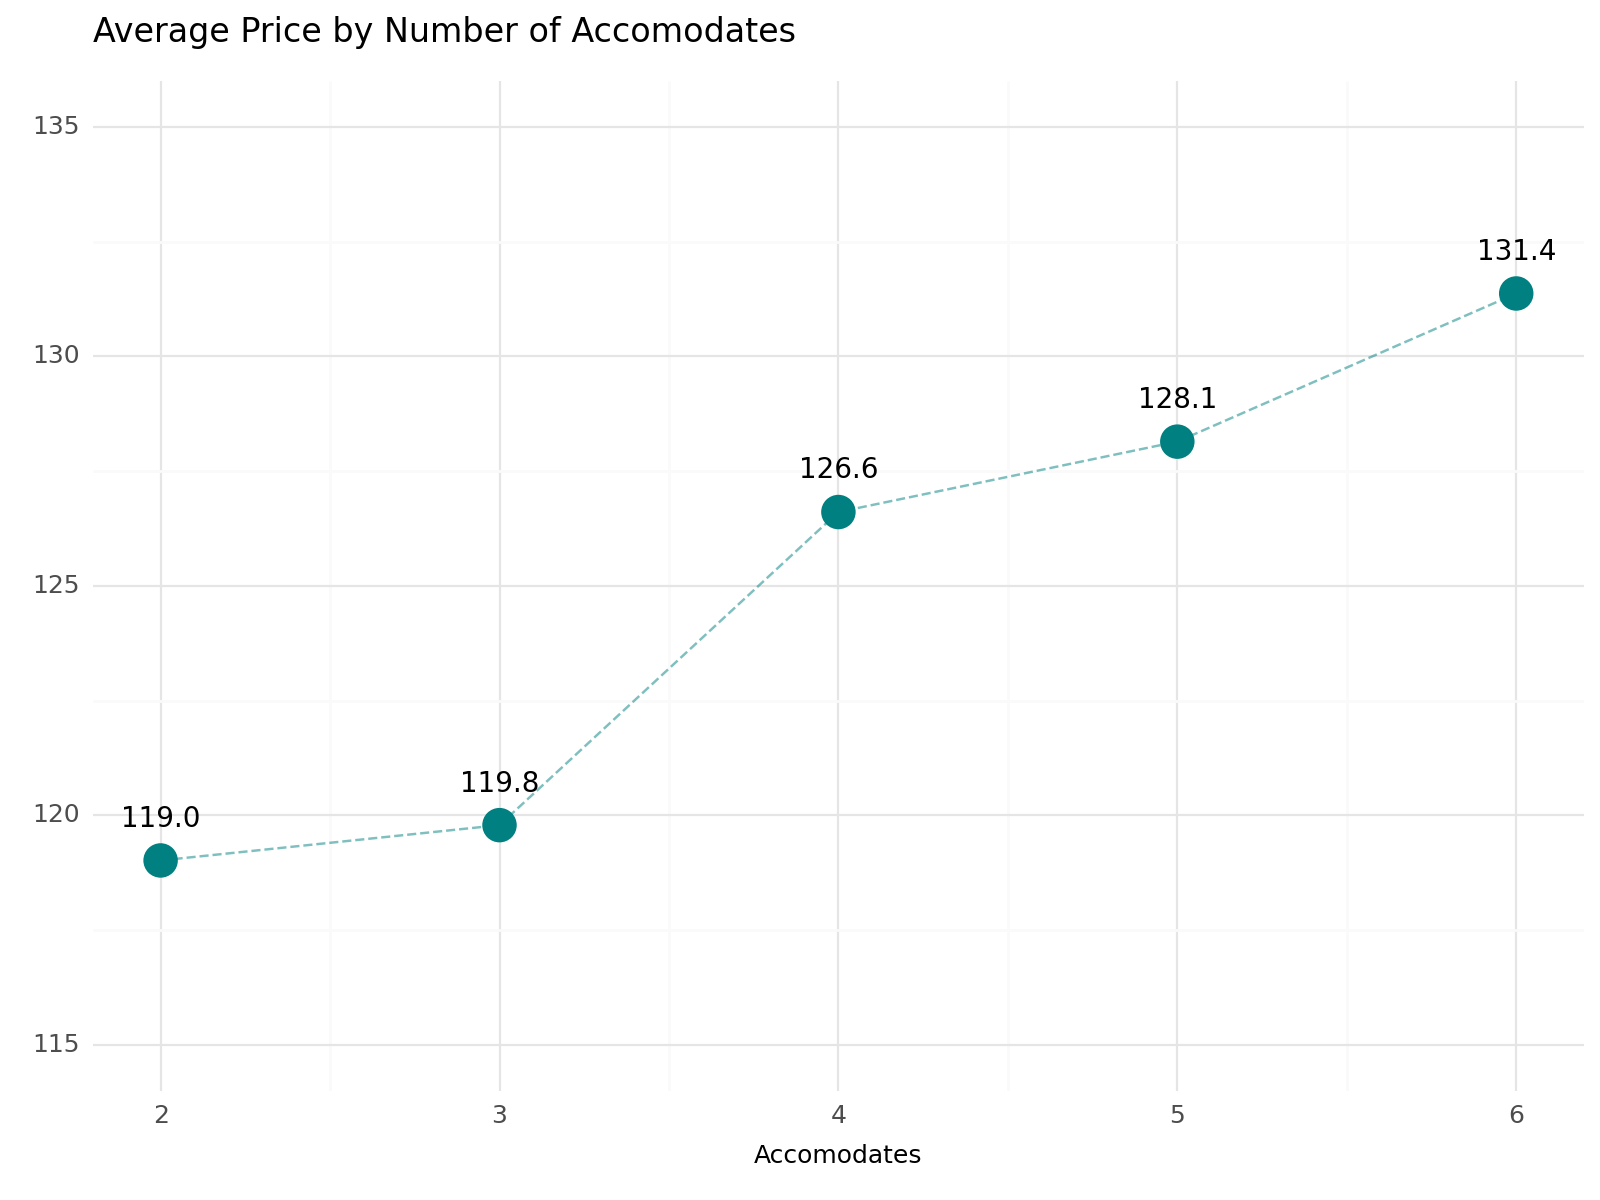

<Figure Size: (800 x 600)>

In [169]:
(
    ggplot(graph3_df, aes(x='Accommodates', y='Average Price', label='Average Price')) +
    geom_point(size=6, color='#008080') +
    geom_line(color='#008080', alpha=0.5, linetype = 'dashed') + 
    geom_text(size=10, nudge_y=0.6, va='bottom', format_string='{:.1f}') +
    theme_minimal() +
    labs(x='Accomodates', y='', title='Average Price by Number of Accomodates') +
    scale_y_continuous(limits=(115, 135)) +
    theme(
        plot_title=element_text(size=12),
        axis_text=element_text(size=9),
        axis_title=element_text(size=9),
        figure_size=(8, 6)
    )
)


In [170]:
roomtype_pdp = partial_dependence(
    rf_pipeline, data_holdout[predictors], ["f_property_type"], kind="average"
)

In [171]:
graph4_df = pd.DataFrame(
    {'Property Type': roomtype_pdp['values'][0], 
     'Average Price': roomtype_pdp['average'][0]}
    ).sort_values(by = 'Average Price')
graph4_df

,Property Type,Average Price
2,Home,123.904349
1,Condo,124.833347
3,Loft,125.225683
0,Apartment,125.776748


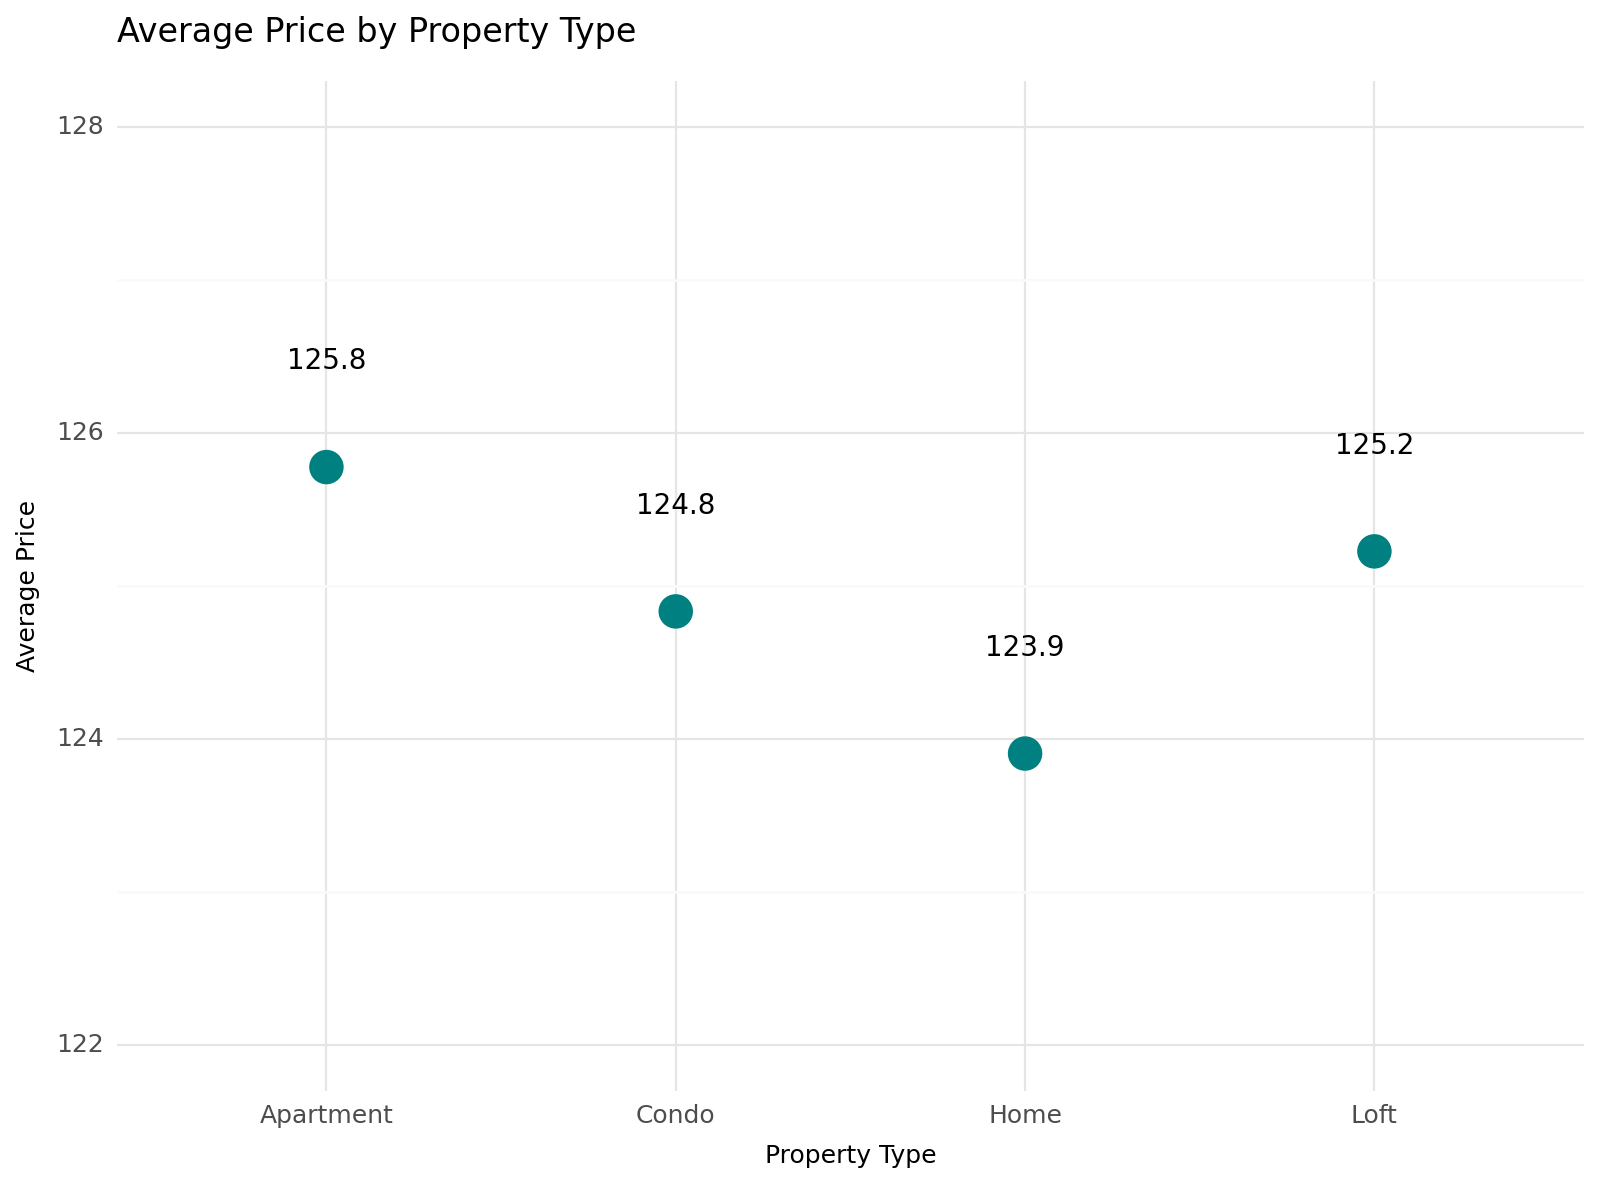

<Figure Size: (800 x 600)>

In [172]:
(
    ggplot(graph4_df, aes(x='Property Type', y='Average Price', label='Average Price')) +
    labs(x='Property Type', y='Average Price', title='Average Price by Property Type') + 
    geom_point(size=6, color='#008080') +  
    geom_text(size=10, nudge_y=0.6, va='bottom', format_string='{:.1f}') + 
    theme_minimal() +
    scale_y_continuous(limits=(122, 128)) +
    theme(
        plot_title=element_text(size=12), 
        axis_text=element_text(size=9), 
        axis_title=element_text(size=9),
        figure_size=(8, 6)
    )
)

# Comparison
comparing RMSE of our models

In [181]:
results = pd.DataFrame({'Model': ['OLS', 'LASSO', 'CART', 'Random Forest', 'GBM'],
              'CV RMSE': [ols_rmse, lasso_rmse, cart_rmse, rf_rmse, gbm_rmse]})
results = results.sort_values(by='CV RMSE', ascending=True).reset_index(drop=True)
results.round(3)

,Model,CV RMSE
0,GBM,36.922
1,OLS,37.496
2,LASSO,38.740
3,Random Forest,39.614
4,CART,42.870


# Prediction

#### 